# Анализ оттока и сегментирование клиентов банка "Метанпром".

# Описание проекта

Банк Метанпром - региональный банк с офисами в Ярославле, Великом Ростове и Рыбинске. 
Заказчик - отдел маркетинга банка Метанпром.

<b> Цель исследования - </b> подготовить сегментацию клиентов, которые склонны уходить из банка, для разработки стратегии по сокращению их оттока.

# План работы:

1. [Загрузка и предобработка данных](#load_data) 
2. [Исследовательский анализ данных](#analysis) <br>
2.1 [Оценка уровня оттока в зависимости от дохода и баланса](#balance_salary_churn)  <br>
2.2 [Анализ оттока клиентов в разрезе возрастных групп](#age_churn)  <br>
2.3 [Анализ оттока клиентов в разрезе продуктов и баллов собственности](#ep_churn)<br>
2.4 [Корреляционный анализ](#correlation)<br>
3. [Проверка гипотез](#hypothesis)  <br>
4. [Предварительные выводы и сегментация](#segmentation) <br>
5. [Общие выводы](#conclusions)<br>

# Описание данных

Датасет содержит данные о клиентах банка «Метанпром». Информация предоставлена со стороны заказчика (отдел маркетинга), порядок сбора и формирования данных в полной мере не раскрыт.

Файл с данными - `bank_scrooge.csv`.

В файле `bank_scrooge.csv` содержится следующая информация:
- `USERID` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — количество баллов собственности (0 - минимальное, 9 - максимальное, чем больше объектов находится в собственности у клиента, тем выше балльность в рамках данного признака),
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — наличие кредитной карты у клиента,
- `last_activity` — активный клиент (любая активность клиента за последние 3-4 месяца),
- `EST_SALARY` — оценочный среднемесячный доход клиента (включает не только данные о заработной плате, а также иные поступления на счета, в частности, дивиденды, пенсионные выплаты, возвраты со стороны ИМНС и иные поступления на счета),
- `сhurn` — признак оттока.

<a id="load_data"></a>
# Загрузка и предобработка данных

In [6]:
import pandas as pd
import numpy as np
import phik
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; 
from scipy import stats as st
from scipy.stats import chi2_contingency
import os
from IPython.display import set_matplotlib_formats
import missingno as msno
from plotnine import (
    ggplot,
    aes,
    after_stat,
    stage,
    geom_bar,
    geom_text,
    geom_label,
    position_dodge2,
    facet_wrap,
)
from plotnine.data import mtcars

#register_matplotlib_converters()
#import warnings; warnings.filterwarnings(action = 'ignore')

In [7]:
#sns.set()
sns.set_theme(style="darkgrid", palette="pastel")

Откроем файл и изучим предоставленные нам данные

In [11]:
# функция для вывода основных характеристик датафрейма

def data_info(data):
    print(f'\033[1;30m количество строк: \033[0m {data.shape[0]} \n \
          \n\033[1;30m количество столбцов: \033[0m {data.shape[1]}\n')
    print('\033[1;30m информация о датафрейме: \033[0m\n')
    data.info()
    print('\n\033[1;30m выборочные пять строк датафрейма: \033[0m')
    display(data.sample(5))
    print('\n\033[1;30m количество пропусков в столбцах: \033[0m')
    display(data.isna().sum().sort_values())
    print('\n\033[1;30m количество явных дубликатов: \033[0m', data.duplicated().sum())
    print('\n\033[1;30m описание числовых столбцов: \033[0m')
    display(data.describe())

In [12]:
print('\n\033[1;30m таблица: bank_scrooge \033[0m\n')
data_info(data)


 таблица: bank_scrooge 

 количество строк:  10000 
           
 количество столбцов:  12

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB

 выборочные пять строк датафрейма: 


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
6147,179850,942.0,Ярославль,М,54.0,0,NaN,1,1,0,186022.12,0
73,155403,859.0,Рыбинск,М,56.0,5,652553.80,2,1,1,60791.77,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
2513,228294,887.0,Ярославль,М,32.0,5,606119.83,2,1,1,68285.78,0
715,156108,824.0,Ярославль,М,60.0,5,2814918.06,2,1,0,76827.89,0



 количество пропусков в столбцах: 


USERID              0
score               0
city                0
gender              0
equity              0
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
age                26
balance          2295
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


- общее число строк в датасете - 10 тысяч строк,
- наименование столбцов USERID, EST_SALARY необходимо привести к змеиному регистру,
- присутствуют пропуски в столбцах с возрастом клиентов (age) и балансом на счете (balance),
- тип данных в столбце с возрастом (age) изменим с float на int,
- явные дубликаты отсутствуют,
- минимальный возраст клиента - 18 лет, максимальный - 86. 75% клиентов младше 51 года, медианный возраст 40 лет,
- в столбце balance - медианное значение ~ 525 тысяч ден. ед., когда среднее ~ 830 тысяч ден. ед., что говорит нам о сильном разброс значений (минимальное значение 0, максимальное около 120 миллионов ден. ед.),
- присутствует сильный разброс значений в столбце с оценочным доходом клиентов - минимальное значение 2.5 тысячи, максимальное - 1.4 миллиона, среднее значение ~ 150 тысяч, медианное ~ 120 тысяч ден. ед.,
- минимальное количество продуктов у клиентов банка - 0, максимальное - 5, медианное / среднее - 2 продукта (отдельно обратим внимание на клиентов с нулевым числом продуктов, т.к. технически данные лица по сути уже могут не быть клиентами банка), 
- по предоставленным данным отток клиентов составляет 18.2% от общего числа клиентов в датасете.

<b> Приведем названия столбцов к нижнему/змеиному регистру

In [14]:
data.rename(columns = {'USERID':'user_id', 'EST_SALARY':'est_salary'}, inplace=True)

In [15]:
# рассмотрим уникальные значения в столбцах

for columns in data[['score', 'city','gender', 'age', 'equity', 'balance', 'products', 'credit_card',\
                     'last_activity', 'est_salary', 'churn']]:
    print(f'\nуникальные значения в столбце \033[1;4;30m{columns}\033[0m\n',data[columns].unique())


уникальные значения в столбце score
 [ 850.  861.  892.  866.  730.  856.  807.  825.  923.  906.  927.  921.
  845.  837.  815.  731.  829.  793.  876.  922.  772.  896.  871.  732.
  898.  806.  766.  776.  868.  946.  828.  786.  944.  863.  822.  794.
  924.  811.  814.  956.  935.  826.  849.  901.  893.  792.  888.  831.
  748.  820.  860.  914.  930.  948.  789.  737.  812.  933.  809.  749.
  873.  859.  950.  937.  835.  768.  767.  785.  846.  750.  816.  894.
  891.  788.  758.  787.  821.  855.  779.  791.  838.  971.  797.  841.
  915.  985.  870.  897.  763.  774.  686. 1000.  875.  819.  869.  854.
  810.  761.  802.  958.  917.  745.  736.  908.  928.  884.  853.  780.
  726.  881.  975.  852.  965.  899.  890.  836.  818.  880.  795.  916.
  775.  902.  918.  842.  771.  895.  801.  721.  966.  804.  885.  986.
  753.  832.  979.  798.  754.  756.  823.  658.  734.  954.  827.  929.
  760.  688.  659.  817.  718.  705.  920.  652.  649.  862.  770.  824.
  934.  952. 

In [17]:
# рассмотрим количество данных (по клиентам) в разрезе столбцов

for columns in data[['city','gender', 'age', 'equity', 'products', 'credit_card', 'last_activity', 'churn']]:
    print(f'\nколичество клиентов в разбивке по \033[1;4;30m{columns}\033[0m')
    display(data[columns].value_counts())


количество клиентов в разбивке по city


city
Ярославль    5888
Рыбинск      2695
Ростов       1417
Name: count, dtype: int64


количество клиентов в разбивке по gender


gender
М    5005
Ж    4995
Name: count, dtype: int64


количество клиентов в разбивке по age


age
36.0    414
37.0    402
33.0    392
35.0    388
34.0    384
       ... 
83.0      3
82.0      2
84.0      2
79.0      2
86.0      2
Name: count, Length: 68, dtype: int64


количество клиентов в разбивке по equity


equity
0    2592
5    1918
4    1850
3    1543
2    1052
1     774
6     161
7      80
8      17
9      13
Name: count, dtype: int64


количество клиентов в разбивке по products


products
2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: count, dtype: int64


количество клиентов в разбивке по credit_card


credit_card
1    6804
0    3196
Name: count, dtype: int64


количество клиентов в разбивке по last_activity


last_activity
1    5235
0    4765
Name: count, dtype: int64


количество клиентов в разбивке по churn


churn
0    8180
1    1820
Name: count, dtype: int64

- баллы кредитного рейтинга распределены от 642 до 1000
- клиенты распределены по трем городам: Рыбинск, Ярославль и Ростов, 
- больше всего клиентов из Ярославля - 5888 человек, далее следует Рыбинск (2695) и Ростов (1417),
- пол клиента не содержит аномалий и представлен "М" и "Ж", по половому признаку клиенты распределены практически поровну,
- количество баллов собственности (equity) находится в диапазоне от 0 до 9, больше всего клиентов, у которых нет собственности (0 баллов), далее 5 и 4 балла,
- у 6804 клиентов имеется кредитная карта,
- столбец last_activity говорит о факте любой активности клиента за последнее время, в рамках предоставленного датасета 5235 клиентов оцениваются как активные клиенты,
- возраст большинства клиентов в диапазоне 33-37 лет.

<b> Рассмотрим данные с нулевым значением в столбце products

In [18]:
data.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


У нас имеется только 1 клиент, который не пользуется продуктами банка, это лицо пенсионного возраста, кредитная карта, как и активность за последнее время - отсутствуют, и она (пол - женский) уже определена в отток.
Считаем возможным удалить данного клиента из датафрейма с учетом единичности данного случая и отсутствия какой-либо информативности данного клиента для анализа (с учетом нулевых значений по большинству показателей)

In [19]:
data = data[data['products'] != 0]

<b> Выявим неявные дубликаты в датафрейме

In [21]:
display(data[data.duplicated(subset=['user_id', 'gender', 'age'], keep=False)])

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3274,155765,863.0,Ярославль,М,30.0,5,1036114.50,5,1,1,150744.50,1
5197,155765,923.0,Рыбинск,М,30.0,0,NaN,1,1,1,120296.60,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0


По выявленным данным мы видим задвоение по введенным выше показателям, включая user_id. При этом у выявленных клиентов есть различия в иных столбцах с данными, таких как город, скоринговый балл и баллы собственности, а также число действующих продуктов.
Вероятнее всего это техническая ошибка, но возможно и наличие у клиентов нескольких счетов в разных подразделениях банка, открытых к примеру для получения зачислений в рамках выполненных работ или оказанных услуг для соответствующих контрагентов.
Посмотрим на количество дубликатов по полю user_id

In [22]:
display(data[data.duplicated('user_id', keep=False)].sort_values(by='user_id'))

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0
6457,228075,839.0,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0


Кроме одинаковых user_id, у большинства данных имеются те или иные различия по иным столбцам, при этом города преимущественно представлены Рыбинском и Ярославлем. Оценим распределение клиентов с идентичными user_id по городам.

In [23]:
display(data[data.duplicated('user_id', keep=False)].sort_values(by='user_id')['city'].value_counts())

city
Рыбинск      73
Ярославль    73
Name: count, dtype: int64

Поскольку данные между городами распределены ровно 50/50 для пользователей с идентичными user_id, вероятнее всего наличие дубликатов вызвано технической ошибкой при присвоении уникального ID клиента в разных филиалах банка. Отметим данный факт в качестве feedback'a для заказчика, однако удалять данные не будем.

<b> Перейдем к оценке пропусков в датасетах, они были выявлены в столбцах age и balance.

In [24]:
# пропуски в столбце age

data.query('age.isna()').sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8785,127440,663.0,Ярославль,М,NaN,0,NaN,1,1,1,117197.56,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
9819,140934,832.0,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0
9457,141945,929.0,Ярославль,М,NaN,0,NaN,1,1,0,381868.89,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
9667,163657,849.0,Ярославль,М,NaN,4,1254013.85,2,1,1,119106.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0
9632,185829,927.0,Ярославль,М,NaN,0,NaN,1,1,0,231254.86,0
9380,187459,894.0,Рыбинск,М,NaN,0,NaN,1,1,0,178012.28,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0


26 строк с пропусками в столбце с возрастом клиента: явный признак, по которому возможно оценить причину пропусков, отсутствует. Посмотрим есть ли данные клиенты в списке с лицами, у которых задвоен user_id.

In [28]:
# создадим переменную для сопоставления числа удаленных строк к первоначальной таблице в рамках исключения дубликатов
print(f'Число удаленных данных составит {len(data.query("age.isna()"))/ data.shape[0]:.2%} данных.')

Число удаленных данных составит 0.26% данных.


Число строк с пропусками в возрасте несущественно, удалим данные из датафрейма и приведем тип данных в столбце к integer.

In [29]:
data = data.dropna(subset=['age'])

In [30]:
data['age'] = data['age'].astype('int64')

In [32]:
# посмотрим на пропуски в столбце balance

data.query('balance.isna()')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53,0,NaN,1,0,0,147094.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Ростов,М,38,0,NaN,1,0,0,171763.69,0
9984,125941,729.0,Ярославль,Ж,42,0,NaN,1,1,1,687538.70,0
9993,219924,884.0,Рыбинск,Ж,36,0,NaN,1,1,1,169844.88,0
9996,139170,894.0,Ярославль,М,46,0,NaN,1,1,0,196898.29,0


In [33]:
print(f'Число пропусков в столбце balance составляет 2278 строк, или'
    f' {len(data.query("balance.isna()"))/ data.shape[0]:.2%} остаточных данных.')

Число пропусков в столбце balance составляет 2278 строк, или 22.84% остаточных данных.


Число пропусков существенно, попробуем разобраться в их природе и возможности заполнения медианным или иным значением.

Для начала посмотрим на средние значения признаков группируя по пропускам в balance.

In [37]:
data.drop(['user_id', 'balance'], axis= 1).groupby(data['balance'].isnull()).mean(numeric_only=True)

,score,age,equity,products,credit_card,last_activity,est_salary,churn,gender_code,rostov,rybinsk,yaroslavl
balance,,,,,,,,,,,,
False,843.74412,42.924366,3.394802,2.081222,0.640156,0.515140,124520.394264,0.234698,0.516699,0.153476,0.272515,0.574009
True,865.31475,42.076822,0.050044,1.163740,0.815628,0.549166,226433.776313,0.005268,0.441615,0.103161,0.256804,0.640035


`False` - значение баланса заполнено  
`True` - значение баланса пропущено  

Следует отметить различия в ряде показателей для пользователей с заполненными и отсутствующими данными о балансе (в среднем):
- оценочный доход у пользователей с отсутствующими данными о балансе (est_salary) фактически в 2 раза превышает доход у пользователей с наличием данных о балансе,
- число продуктов у лиц с данными о балансе - около 2, без данных о балансе - около 1,
- баллы собственности у лиц с отсутствием данных о балансе около нуля, у лиц с наличием данных о балансе - около 3х,
- признак отточности по пользователям без данных о балансе - также около нуля, только 1% из них попадает в отток, по пользователям с данными о балансе - 23,5%.

In [39]:
discrete_list = ['gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn', 'city']
non_discrete_list = ['score', 'age', 'balance', 'est_salary']

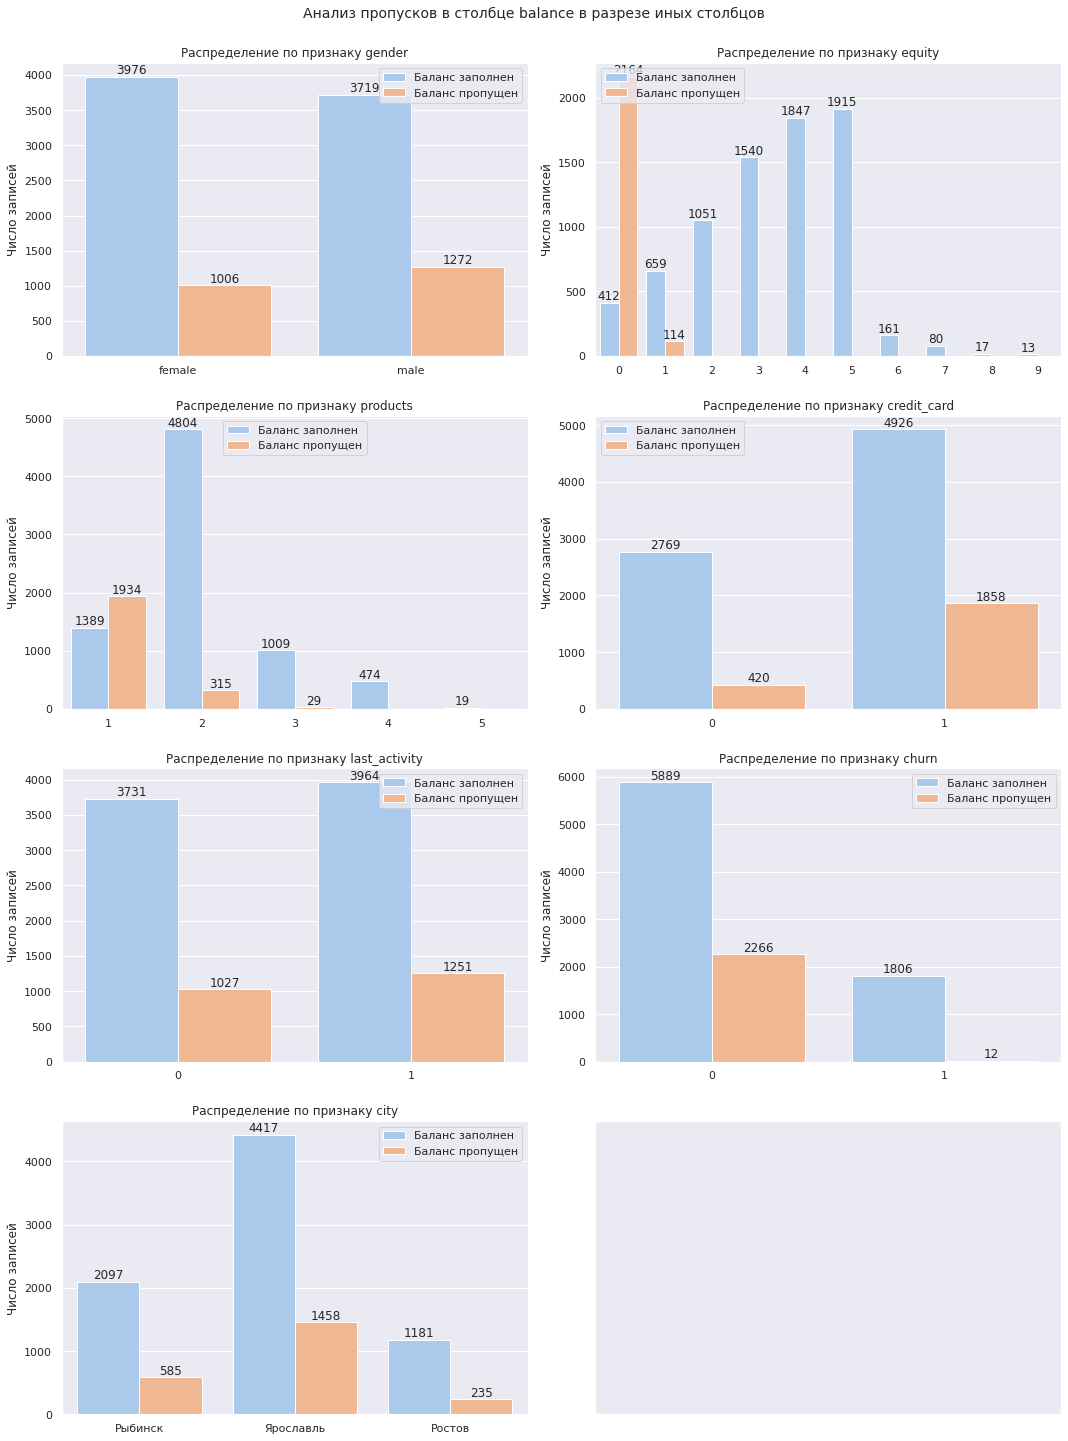

In [40]:
columns = discrete_list

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

plt.subplots_adjust(hspace=1)

fig.suptitle('Анализ пропусков в столбце balance в разрезе иных столбцов', fontsize=14, y=1)

for column, ax in zip(columns, axs.ravel()):
    sns.countplot(data=data, x=column, hue='balance_na', ax=ax)
    ax.set_title(f'Распределение по признаку {column}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Число записей', fontsize=12)
    ax.legend(['Баланс заполнен', 'Баланс пропущен'])
    
    for container in ax.containers:
        ax.bar_label(container)

# уберем подписи с 8-го графика ввиду анализа 5 платформ
ax1 = plt.subplot(4,2,8)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_ticks([])
ax1.axes.yaxis.set_ticks([])

plt.tight_layout(h_pad= 2)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


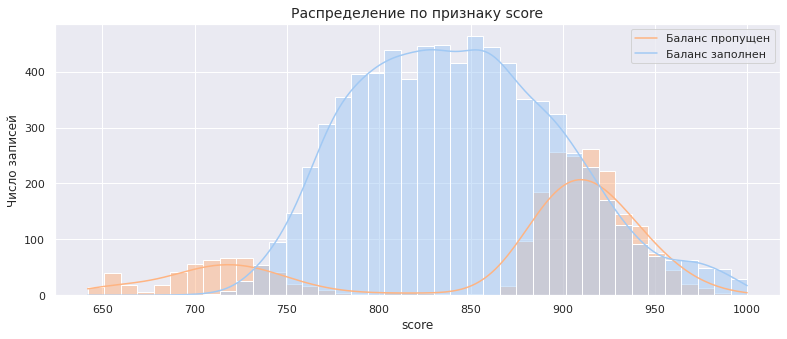

/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


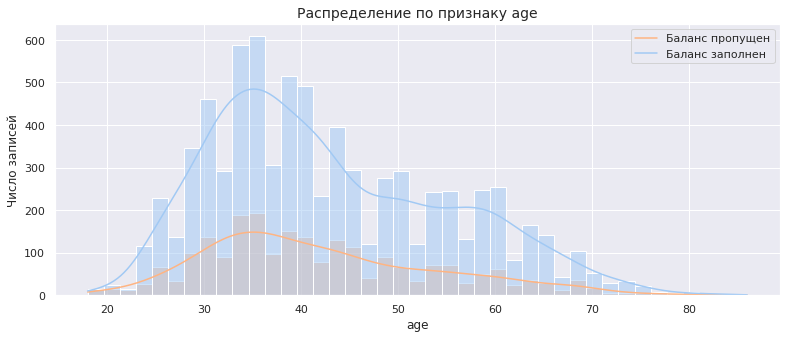

/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


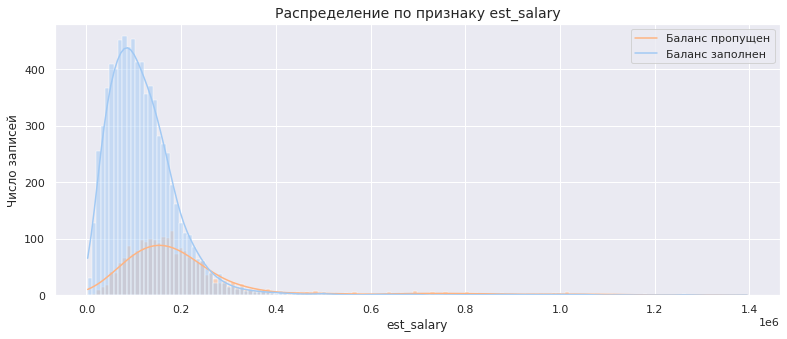

In [41]:
# построим гистограммы для количественных величин, за искл. balance:
for column in ['score', 'age', 'est_salary']:
        
        # зададим параметры графика
        hist, ax = plt.subplots(figsize = (13,5))
        ax = sns.histplot(x = column, data=data, palette='pastel', hue='balance_na', kde=True)

        # зададим подписи осей и графика
        ax.set_title(f'Распределение по признаку {column}',fontsize = 14)
        ax.set_xlabel(f'{column}')
        ax.set_ylabel('Число записей', fontsize = 12)
        plt.legend(['Баланс пропущен', 'Баланс заполнен'])

        # выведем график на экран
        plt.show()

Наиболее явно пропуски присутствуют у клиентов с нулевым баллом собственности - 2164 пропуска в данных о балансе при общем числе пропусков 2278 штук, около 95% общего числа пропусков. <br>
Также существенное число пользователей у лиц с одним продуктом - 1934 или 85% от общего количества пропусков, или 58% значений от данных с 1 продуктом. <br>
Что касается скорингового балла пропуски расположены преимущественно в районе крайних значений (с максимумом в районе скоррингового балла около 900).

В заключение оценим корреляцию пропусков в данных о балансе с другими столбцами, используя phik-корреляцию (позволяет определять зависимость между категориальными, непрерывными переменными и их комбинациями), расброс значений находится от 0 (нулевая взаимосвязь) до 1 (максимальная взаимосвязь).

In [42]:
corr_phik = data
corr_phik.phik_matrix()[16:]

interval columns not set, guessing: ['user_id', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'gender_code', 'balance_na']


,user_id,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_code,rostov,rybinsk,yaroslavl,city,balance_na
balance_na,0.042237,0.754058,0.097241,0.048488,0.97567,NaN,0.491195,0.244707,0.041669,0.42992,0.381196,0.097241,0.093078,0.016701,0.086595,0.039999,1.0


На основании проведенного графического и количественного анализа, а также по итогу построения матрици корреляции и выявления существенной зависимости в пропусках данных о балансе с рядом иных категорий (скоринговый балл, количество продуктов, баллы собственности, доход и пр.), а также существенного числа пропусков в целом мы видим, что удалять данные пропуски или заполнить их какими-либо медианными значениями будет некорректно.

При предварительной оценке данных мы обратили внимание, что значения в столбцах balance и est_salary имели существенный разброс данных, посмотрим на распределение значений в этих столбцах с помощью boxplot

<Axes: xlabel='balance'>

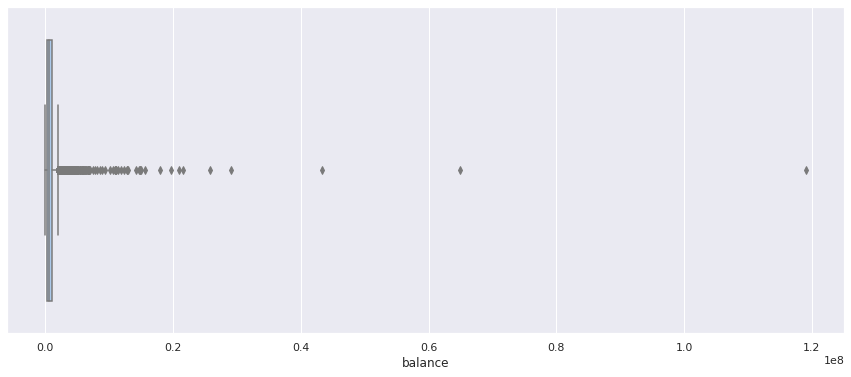

In [43]:
plt.figure(figsize=(15,6))
sns.boxplot(x=data['balance'])

<b> Для удобства работы с данными графиками переведем значения в столбцах balance и est_salary в млн руб.

In [44]:
data['balance'] = data['balance']/1000000
data['est_salary'] = data['est_salary']/1000000

<Axes: xlabel='est_salary'>

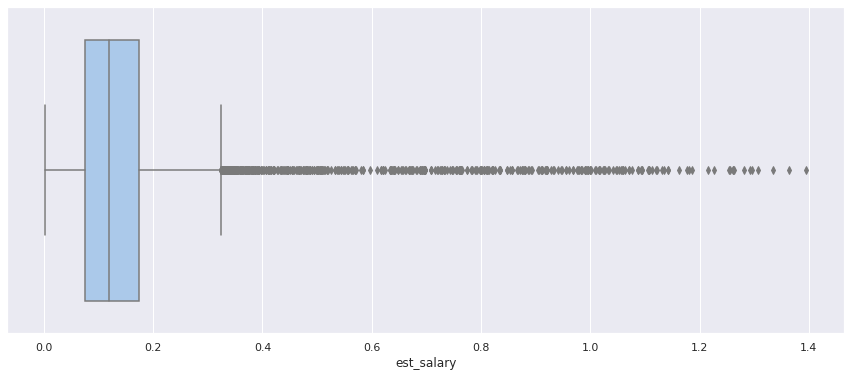

In [46]:
plt.figure(figsize=(15,6))
sns.boxplot(x=data['est_salary'])

In [47]:
#посмотрим на 95-й персентиль по столбцу est_salary
est_95 = np.percentile(data['est_salary'], 95)

In [48]:
#посмотрим на 95-й персентиль по столбцу balance, без уч. пропусков в данных
bal_95 = np.percentile(data['balance'].dropna(), 95)

In [49]:
print(f'Не более 5% клиентов имеют оценочный доход больше {est_95} млн ден. ед.')
print(f'Не более 5% клиентов имеют баланс на счете больше {bal_95} млн ден. ед.')

Не более 5% клиентов имеют оценочный доход больше 0.31636693599999993 млн ден. ед.
Не более 5% клиентов имеют баланс на счете больше 2.1140783939999963 млн ден. ед.


Значения в обоих столбцах характеризуются существенным числом выбросов (по правому хвосту), которые практически полностью находятся выше 95-го персентиля и существенно превышающими медианные и средние значения. Однако, учитывая специфику деятельности анализируемого контрагента (банк), у которого в качестве клиентов присутствуют состоятельные клиенты, исключать данных лиц из анализа мы сочли нецелесообразным, так как данный выбросы могут предоставить нам дополнительную информацию для анализа.

<a id="analysis"></a>
# Исследовательский анализ данных (EDA)

Посмотрим на данные в разрезе тех, кто ушел в отток (1) и кто остался лояльным банку (0).

In [51]:
def aggregate_data(data: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Группирует данные в разрезе задаваемого столбца.

    Аргументы:
        data (pd.DataFrame): датафрейм, содержащие данные к группировке.
        feature (str): название колонки, по которой осуществляется группировка данных.

    Возвращает:
        pd.DataFrame: датафрейм, сгруппированный по указанному столбцу с заданными рассчетными показателями по иным столбцам.
    """
    return (
        data.groupby(feature)
        .agg({
            'gender': pd.Series.mode,
            'city': pd.Series.mode,
            'age': 'mean',
            'score': 'mean',
            'equity': 'mean',
            'products': 'mean',
            'balance': 'median',
            'est_salary': 'median',
            'credit_card': 'mean',
            'last_activity': 'mean',
            'churn': 'mean',
        })
        .round(2)
        .T
    )

In [52]:
# ознакомимся с показателями датафрема в разрезе лояльности / оттока клиентов банку
aggregate_data(data, 'churn')

churn,0,1
gender,female,male
city,Ярославль,Ярославль
age,43.02,41.43
score,845.4,863.36
equity,2.38,3.76
products,1.76,2.38
balance,0.48,0.78
est_salary,0.12,0.13
credit_card,0.71,0.55
last_activity,0.48,0.7


Предварительно по данным таблицы мы видим, что:
- женщины лояльнее мужчин,
- клиенты из Ярославля преобладают, как в числе ушедших, так и лояльных клиентов банка (что в среднем логично, учитывая, что клиенты из Ярославля это ключевая группа в предоставленном датафрейме),
- уровень активности ушедших пользователей за последние 3-4 месяца превышал уровень активности лояльных пользователей,
- средний уровень остатков на счетах, количества продуктов в банке выше у клиентов, прекративших пользоваться услугами банка.

Построим визуализации для наглядного отображения оттока клиентов в зависимости от признаков. 

In [53]:
def plot_feature_distribution(data: pd.DataFrame, feature: str) -> None:
    """
    Построение гистограммы и boxplot в разрезе заданных столбцов и оттока клиентов (hue=churn).

    Аргументы:
    data (pd.DataFrame): датафрейм с данные для построения графиков.
    feature (str): столбец, в разрезе которого оценивается отток клиентов и осуществляется построение графиков.
    """
    plt.figure(figsize=(17, 8))

    # нормализованная гистограмма (с KDE)
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(x=feature, data=data, hue='churn', common_norm=False, stat='density', kde=True, ax=ax1)
    plt.axvline(np.percentile(data[feature].dropna(), 50), ls='--', lw=2, color='r')
    plt.title(f'Распределение клиентов по признаку {feature} и churn')
    plt.legend(['Отток', 'Действующие', f'Медианный уровень значений в столбце {feature}'])

    # Boxplot
    ax2 = plt.subplot(1, 2, 2)
    sns.boxplot(x='churn', y=feature, data=data, ax=ax2)
    
    #  подписи графиков и выведение на экран
    plt.title(f'Диаграмма размаха по признаку {feature} и churn')
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


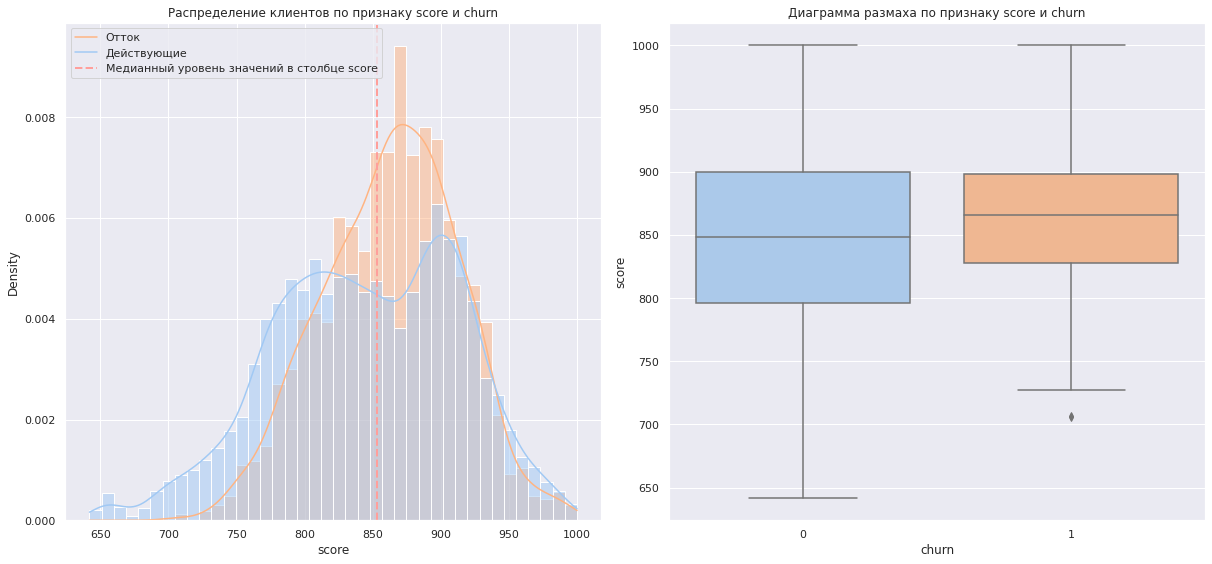

/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


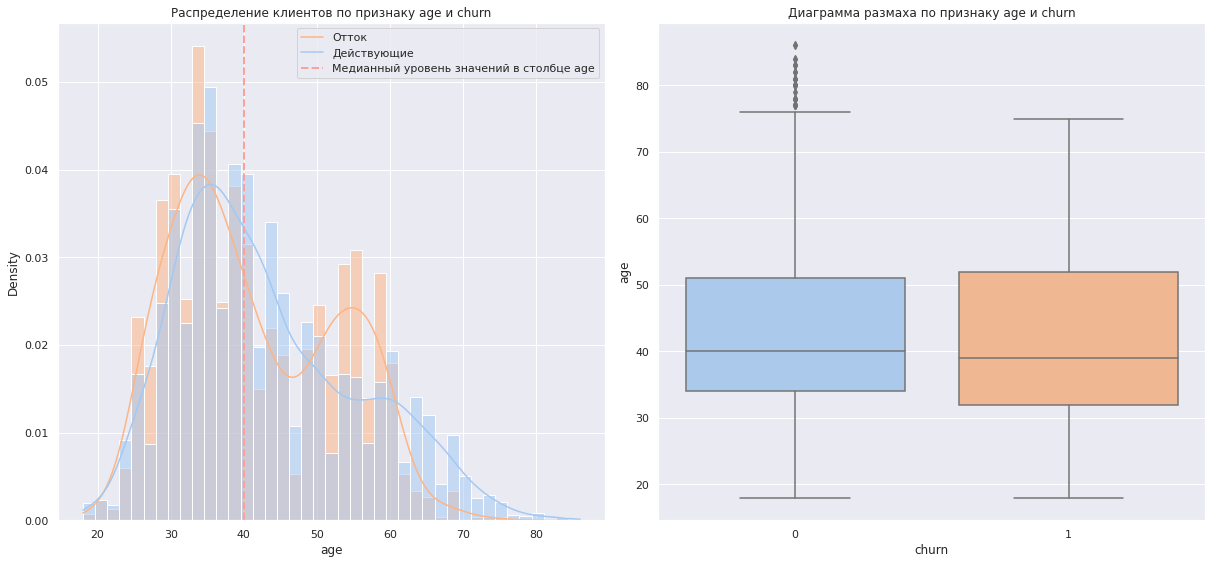

In [54]:
#с помощью функции plot_feature_distribution построим графики распределения для столбцов 'score', 'age'
for feature in ['score', 'age']:
    plot_feature_distribution(data, feature)

Сразу же оценим оставшиеся количественные характеристики данных в разрезе оттока клиентов, а именно с т.зр. уровня дохода и баланса счетов. В части указанных признаков при визуализации используем 99-й персентиль: для большей наглядности графиков из-за значительного разброса данных.

/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


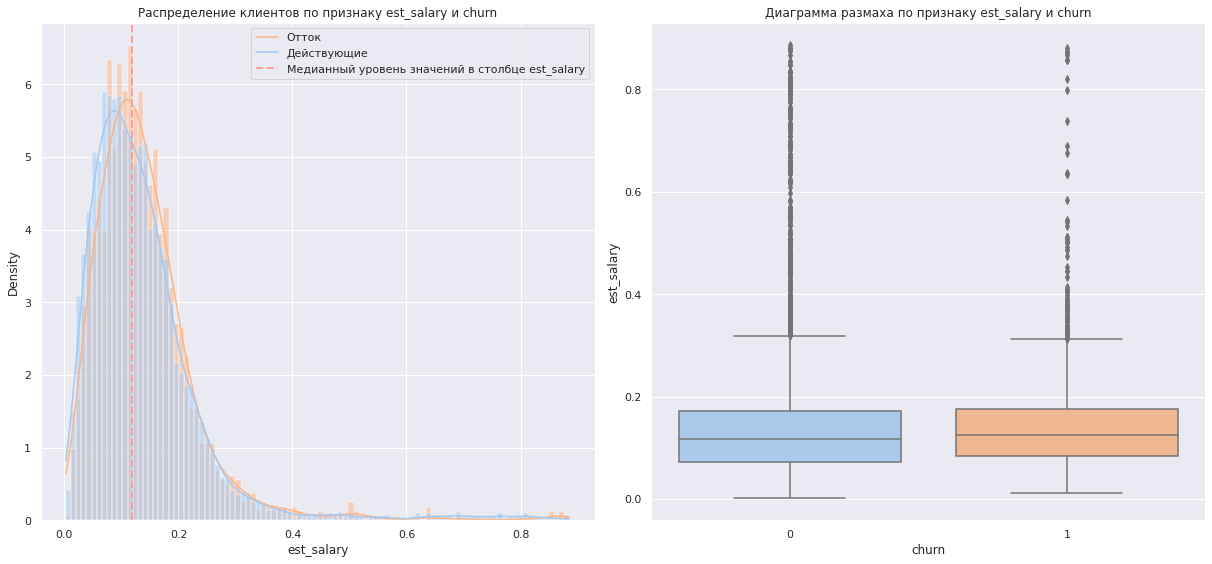

/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


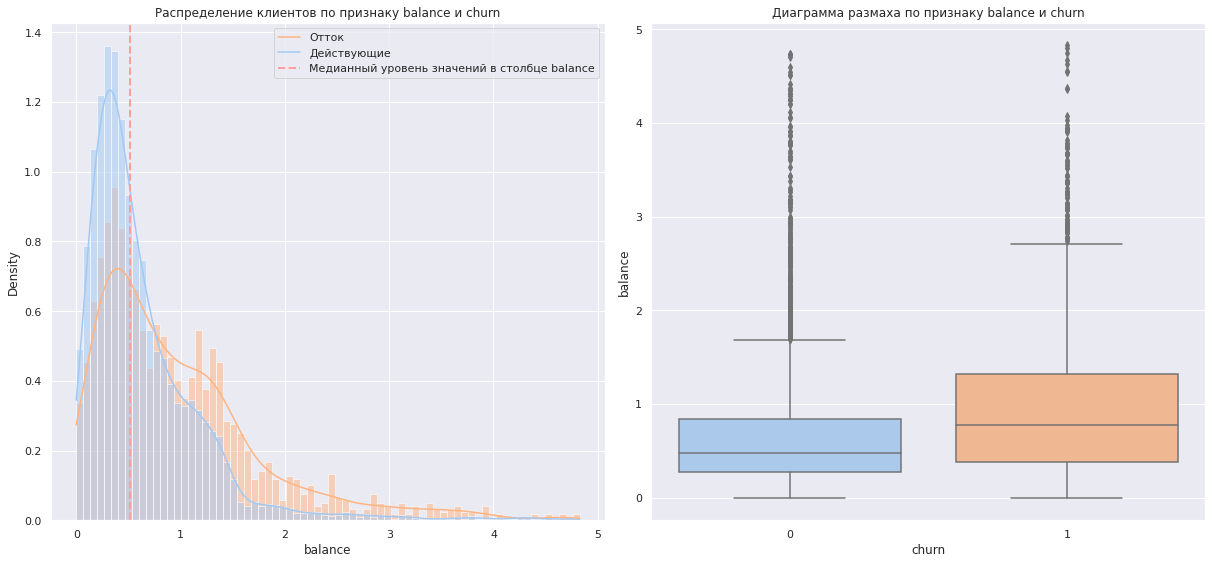

In [55]:
#с помощью функции plot_feature_distribution построим графики для столбцов 'est_salary', 'balance'
for feature in ['est_salary', 'balance']:
    plot_feature_distribution(data[data[feature] <= np.percentile(data[feature].dropna(), 99)], feature)

На основании графиков, построенных выше, можно увидеть, что:
- по признаку баланса на счетах (balance) клиенты с балансом на счете ~ до 800 тысяч с большей вероятностью не попадают в отток, после указанного значения вероятность попадания в отток возрастает. Медианное значение баланса у клиентов в оттоке выше, чем у оставшихся клиентов (~ 750 тысяч против 500 тысяч);
- по оценочному доходу (set_salary) видим схожую тенденцию - клиенты с доходом до 100 тысяч чаще не попадают в отток, далее вероятность попадания в отток увеличивается.
Медианное значение дохода у клиентов, ушедших из банка, выше, нежели у лояльных, однако это различие не столь существенно, как в показателе balance (~ 120-125 тысяч ден. ед. против 100-110 тысяч ден. ед.);
- клиенты со скоринговым баллом до 800 и более 950 с большей вероятностью не попадают в отток, для клиентов с баллом скоринга в интервале 800-950 вероятность попадания в отток возрастает. Медианное значение балла скоринга у клиентов в оттоке незначительно выше (~ 870 против ~850).
- что касается возраста клиентов, то в отток чаще попадают клиенты в возрасте до 35 лет и в возрасте 50-60 лет. Средние и медианные показатели возраста клиентов попавших в отток ниже, чем у лояльных клиентов: средний возраст 41 против 43 и медианный - 39 против 40 лет.

Предварительно можно предположить, что чем выше доход и баланс на счете, тем возрастает вероятность ухода клиента из банка.
Также потенциально может присутствовать некоторая взаимосвязь балла скоринга с уровнем дохода и балансом на счетах.

Перейдем к анализу категориальных величин с целью анализа оттока клиентов:

In [56]:
def plot_churn_by_category(data: pd.DataFrame, columns: list[str]) -> None:
    """
    Заданная функция осуществляет построение графиков в разрезе задаваемых категорий с hue-параметром = churn.
    
    Аргументы:
    data (pd.DataFrame): датафрейм, содержащий данные и категориальные переменные.
    columns (list[str]): наименование категориальных переменных для анализа.
    
    Returns:
    None: изображение графика для каждой категориальной переменной в разрезе признака оттока.
    """
    for column in columns:
        plt.figure(figsize=(17, 12.5))
        ax1 = plt.subplot(2, 1, 1)

        # создаем временную сводную таблицу для расчета процента оттока
        temp1_vc = data.groupby(column)['churn'].value_counts().reset_index(name='count')
        temp1_gc = data.groupby(column)['churn'].count().reset_index(name='churn_total')
        df = data.merge(temp1_vc, on=[column, 'churn']).merge(temp1_gc, on=column)
        df['percentage'] = (df['count'] / df['churn_total']) * 100
        
        # переименовываем колонки и их значения для ясности графика
        df['churn'].replace({0: 'лояльные', 1: 'отток'}, inplace=True)       
        df.rename(columns = {'churn':'Признак оттока клиентов'}, inplace = True)

        # строим barplot
        ax = sns.barplot(x=column, y='count', hue='Признак оттока клиентов', data=df, ax = ax1, hue_order=['лояльные', 'отток'])
       
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            percentage = df.loc[(df['count'] >= height - 0.01) & (df['count'] <= height + 0.01), 'percentage']
            if not percentage.empty:
                ax.text(p.get_x() + width / 2, height, f"{percentage.values[0]:.2f}%", 
                        ha="center", va="bottom", color='black', fontsize=10)

        # задаем названия осей, графика, выводим график на экран
        plt.ylabel('Частота наблюдений')
        plt.title(f'Доли клиентов по признаку {column} в разбивке на churn')
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_201/724404599.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




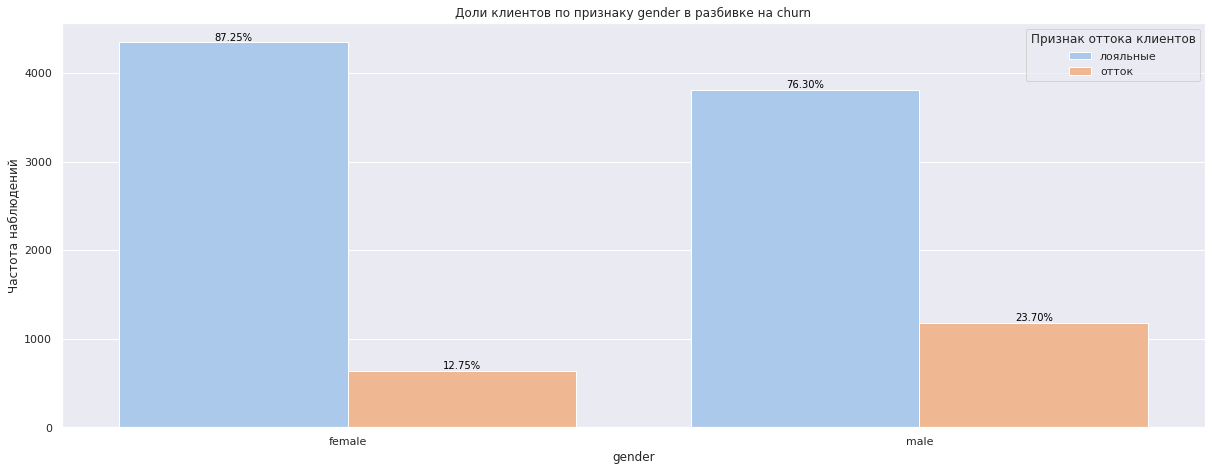

/tmp/ipykernel_201/724404599.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




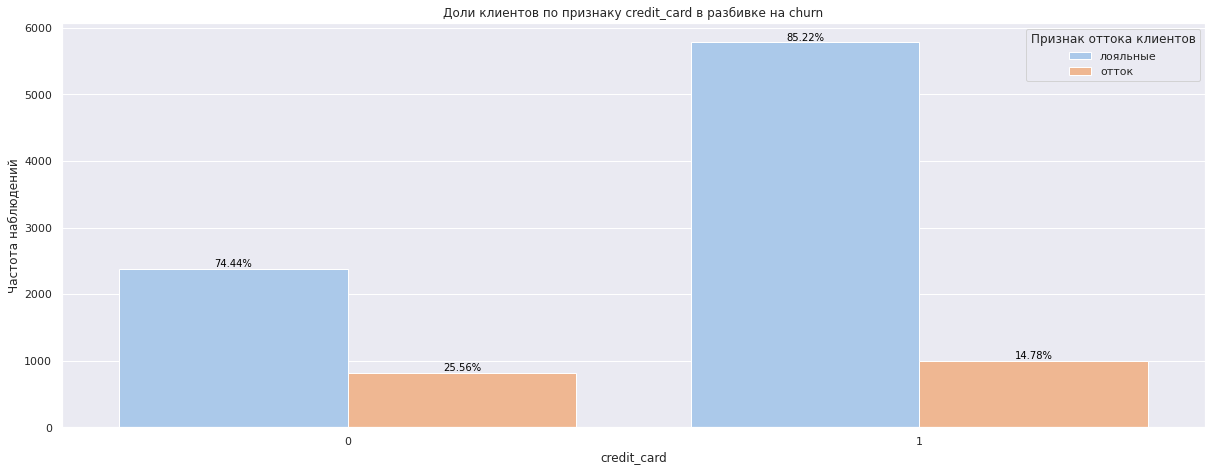

/tmp/ipykernel_201/724404599.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




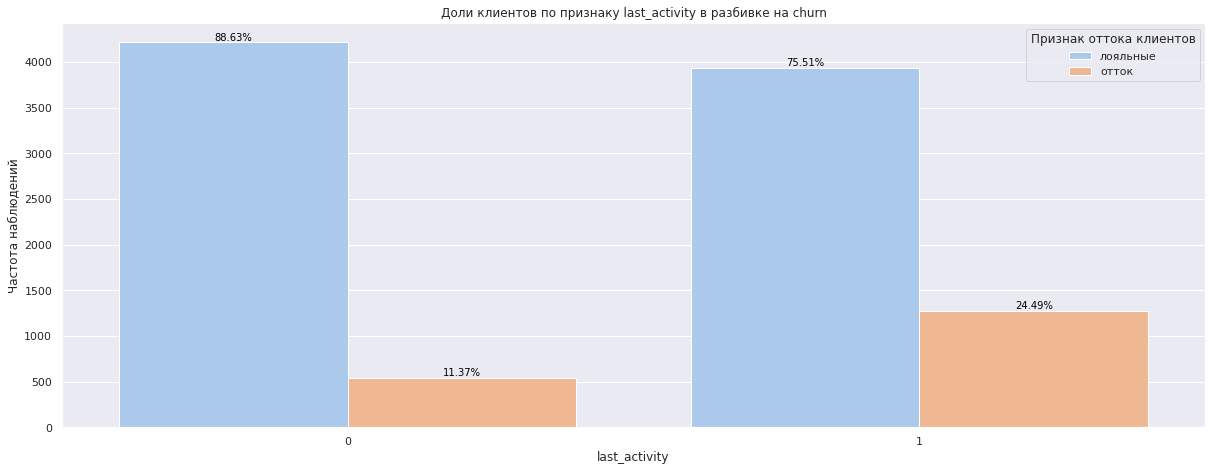

/tmp/ipykernel_201/724404599.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




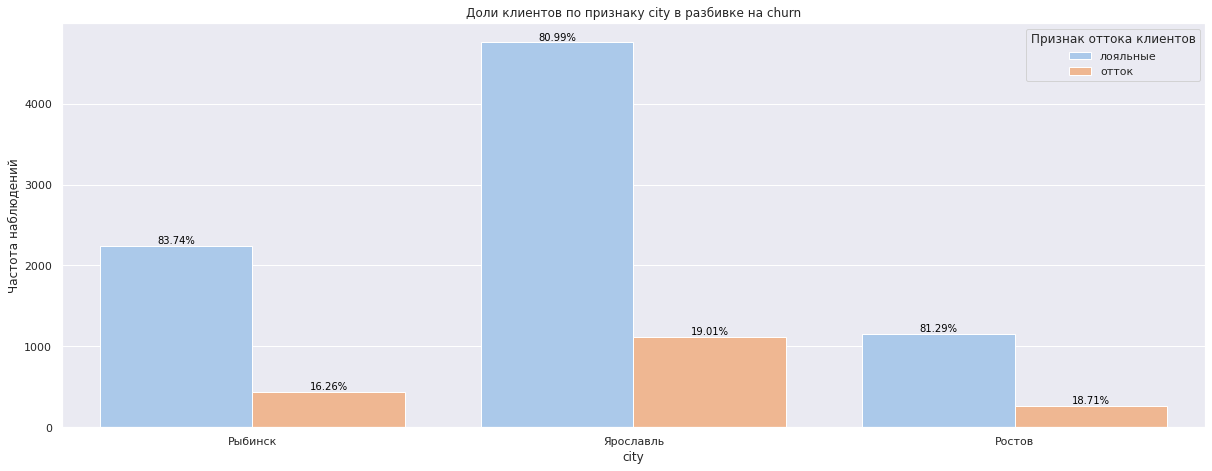

/tmp/ipykernel_201/724404599.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




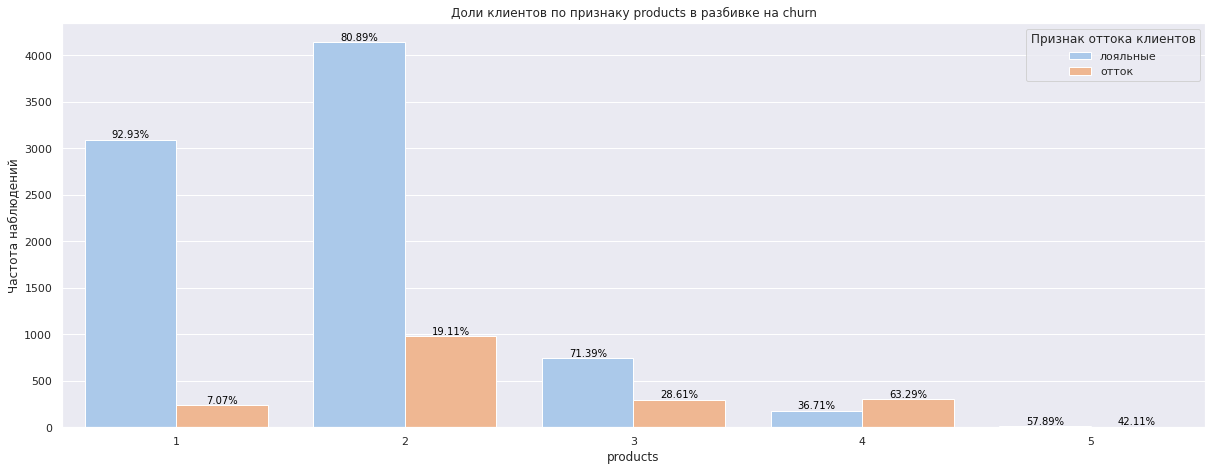

/tmp/ipykernel_201/724404599.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




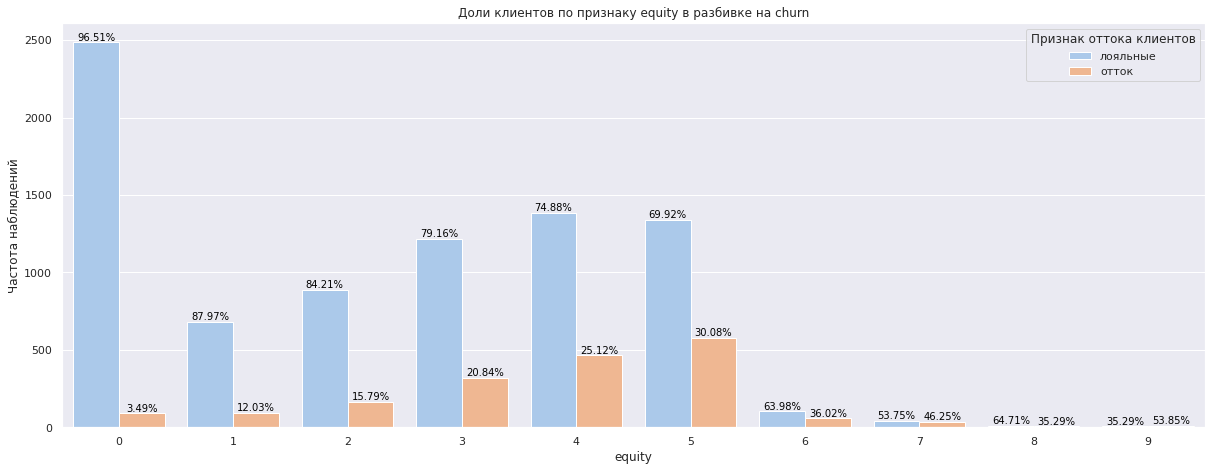

In [57]:
plot_churn_by_category(data, ['gender', 'credit_card', 'last_activity', 'city', 'products', 'equity'])

В предоставленных нам данных:
- мужчины и женщины распределены практически 50/50, при этом уровень оттока среди мужчин фактически два раза выше уровня оттока у женщин (24% против 13%), кроме того:
- доля оттока у пользователей без кредитной карты составляет 26%, клиенты, имеющие кредитную карту, уходят из банка реже - в 15% случаев,
- активные клиенты чаще уходят в отток, нежели неактивные: 24 % против 11% соответственно,
- среди жителей разных городов доли оттока распределены приблизительно одинаково: отток в Рыбинске около 16%, Ярославль и Ростов - около 19%. Вероятнее всего, город проживания на отток клиента из банка в нашем случае не влияет,
- с ростом количества продуктов у клиентов возрастает и доля оттока.Больше всего клиентов - это клиенты, у которых имеются 1 или 2 продукта, доли оттока по данным клиентам составляют 7 и 19 % соответственно. У клиентов с 4 продуктами отток составляет 63%,
- кроме того, доля оттока увеличивается и с ростом баллов собственности. Самая многочисленная группа с баллом собственности 0 показывает минимальный процент оттока - 3%, доля оттока более 18% (среднее значение по всем пользователям) начинается с баллов собственности 3 и более.

Построим диаграмму рассеивания показателей оценочного дохода и кредитного скорринга, в разрезе оттока клиентов.
А также диаграммы размаха оценочного дохода в паре с другими данными таблицы.

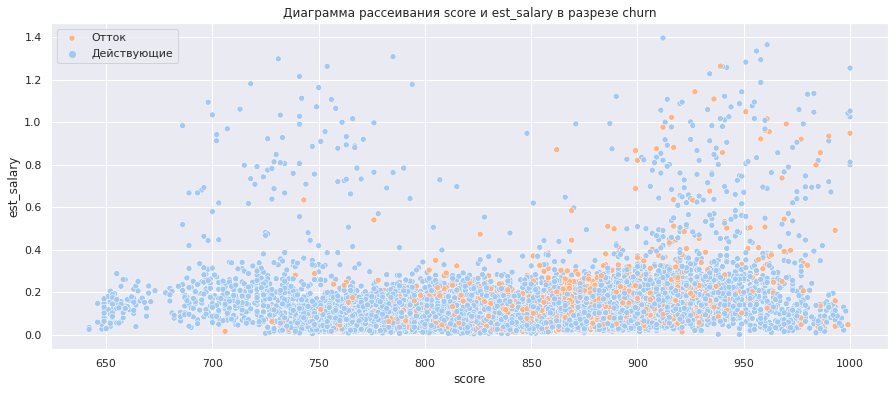

In [67]:
#зададим параметры фигуры 
plt.figure(figsize=(15, 6))

#построим график
sns.scatterplot(data=data, x='score', y='est_salary', hue='churn')

#зададим подписи графика, выведем график на экран
plt.legend(['Отток', 'Действующие'])
plt.title('Диаграмма рассеивания score и est_salary в разрезе churn')
plt.show()

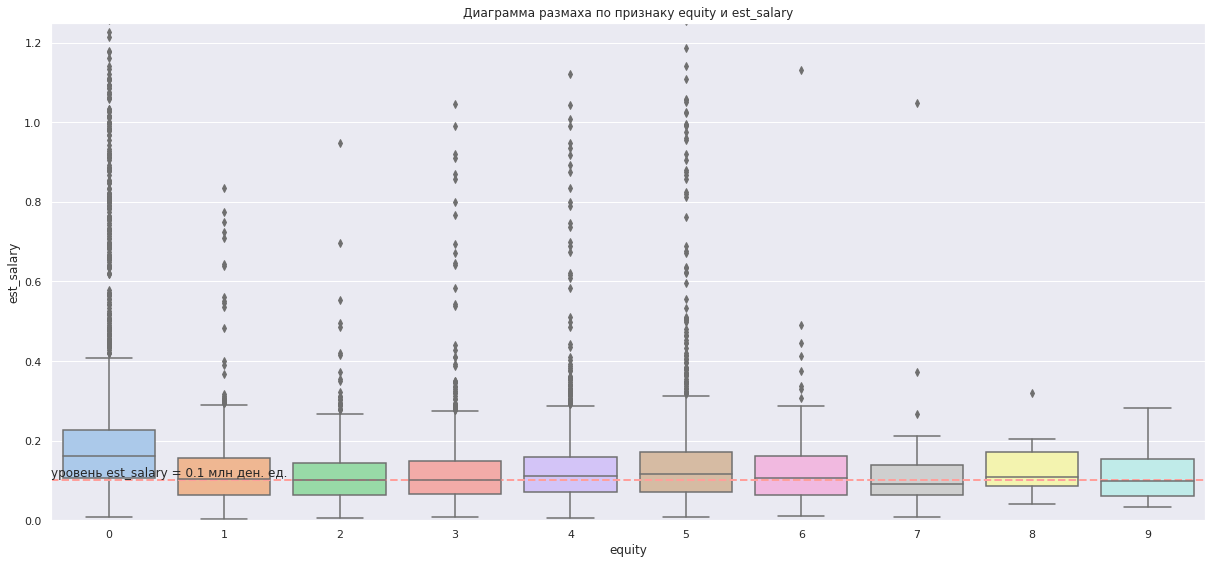

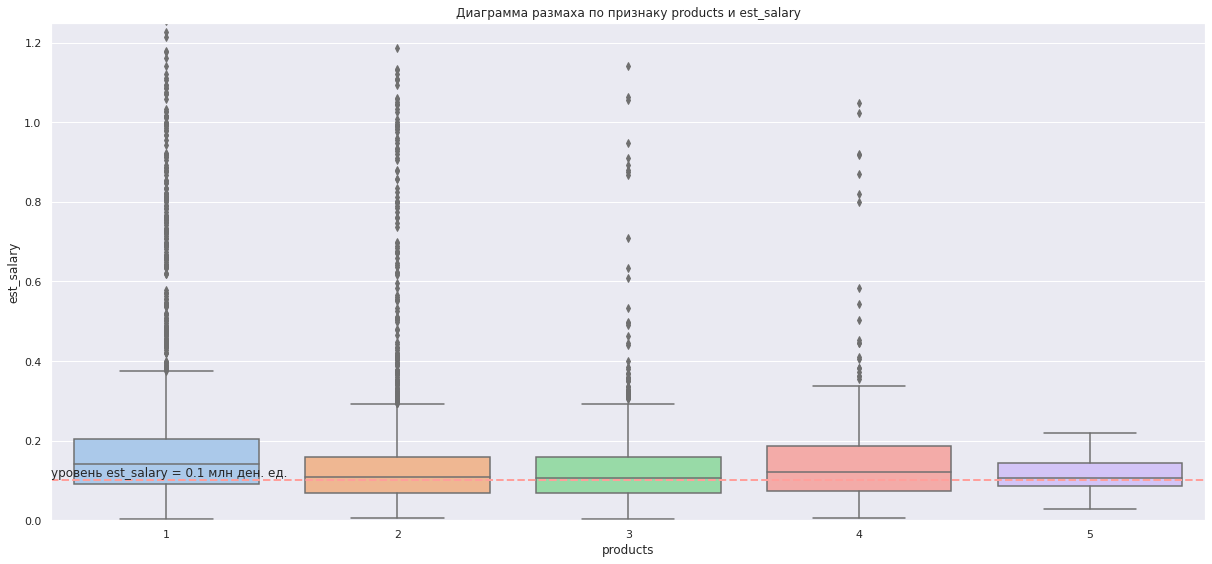

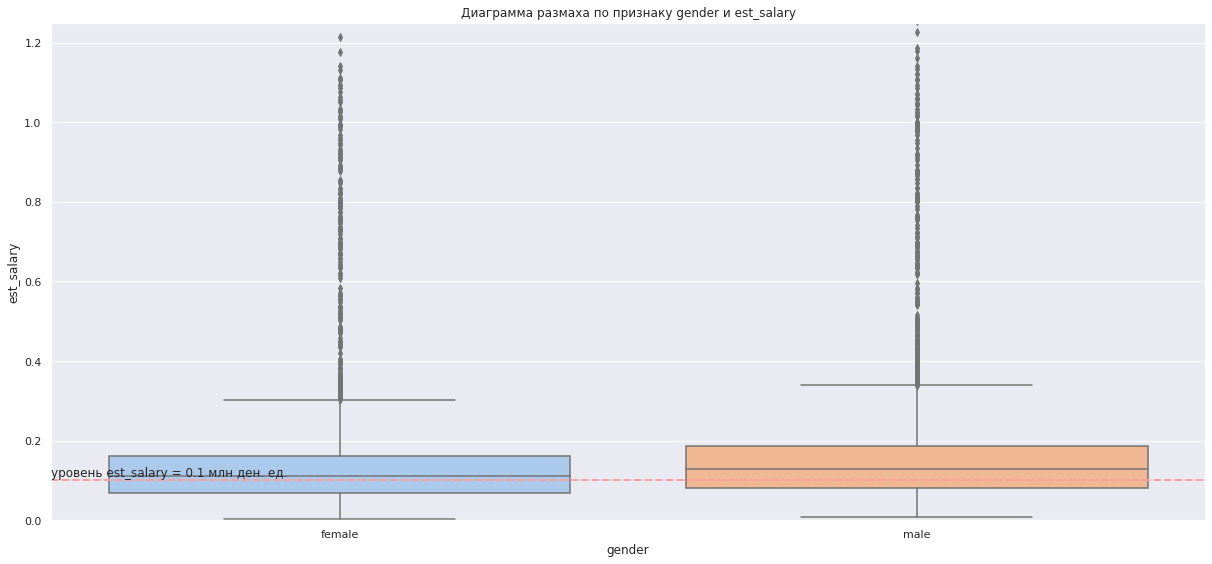

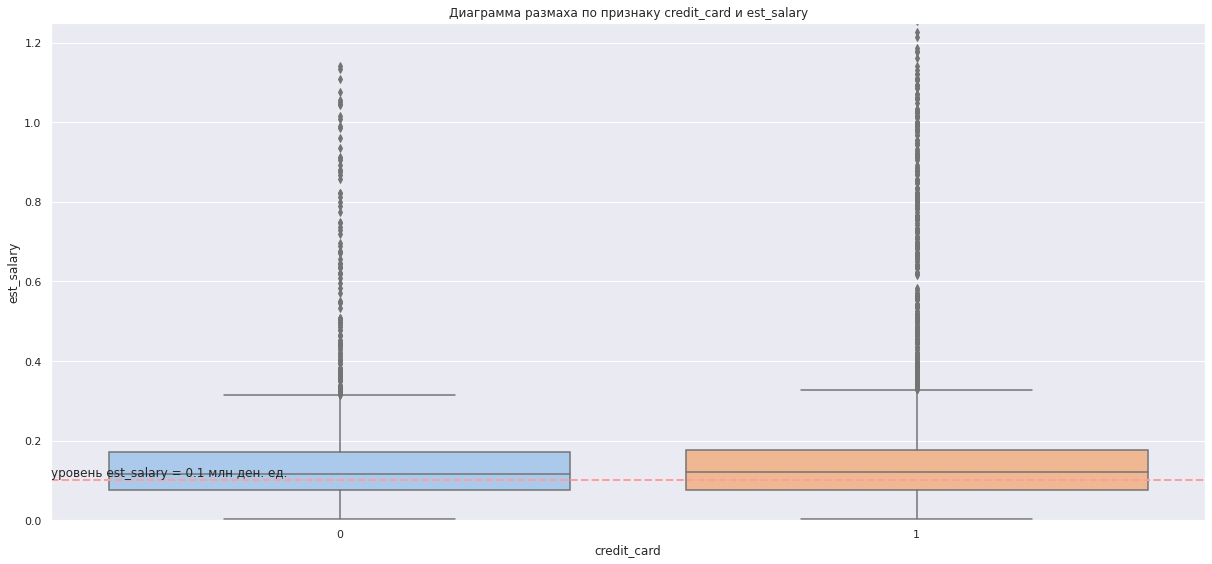

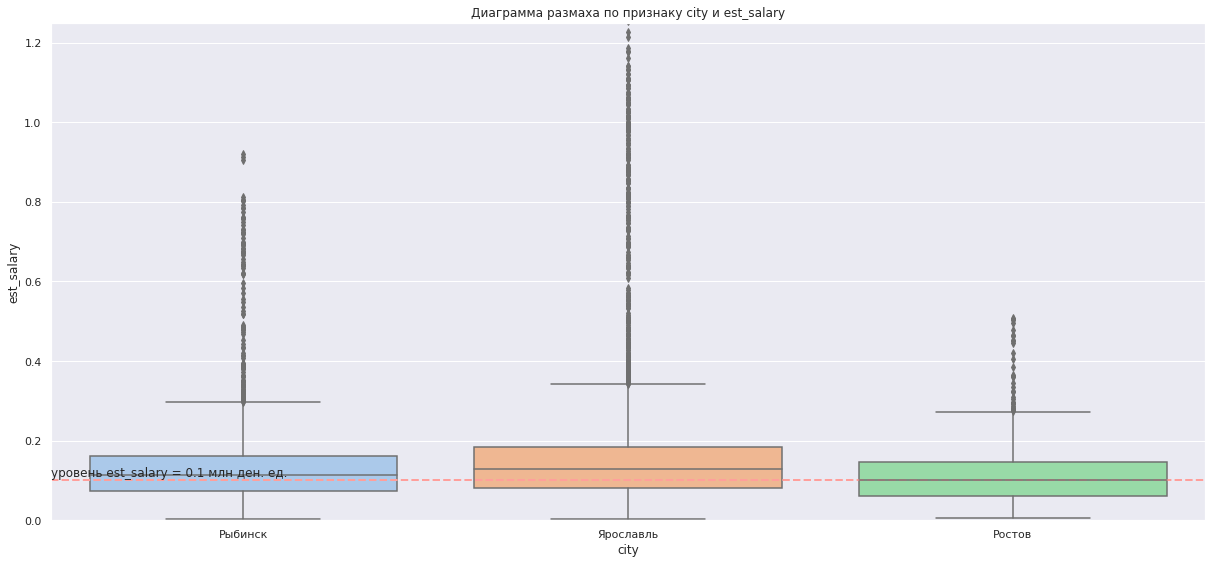

In [68]:
#зададим цикл для выбора столбца из заданных значений
for feature in ['equity', 'products', 'gender', 'credit_card', 'city']:

    #зададим размер графика и его местоположение
    plt.figure(figsize=(17, 8))
    ax1 = plt.subplot(1, 1, 1)
    
    #построим график и горизонтальную линии у заданном уровне balance
    sns.boxplot(x=feature, y = 'est_salary', data=data, ax=ax1)
    ax1.axhline(0.1, ls='--', lw=2, color='r')
    
    #зададим ограничения значений по оси, подпишем графики и выведем на экран
    plt.title(f'Диаграмма размаха по признаку {feature} и est_salary')
    plt.ylim(0, 1.25)
    plt.text(-0.5,0.11, 'уровень est_salary = 0.1 млн ден. ед.')
    plt.tight_layout()
    plt.show()

В соответствии с диаграммой рассеивания ситуация по est_salary и score в целом схожа на распределение и тенденции, характерные для соотношения balance-score, в т.ч. в части незначительно роста est_salary по мере роста score после 900-950 п. и увеличение для существенных значений est_salary и score уровня оттока. <br>

- медианные значения дохода у женщин ниже, чем у мужчин (~ 110 тысяч против 125 у мужчин),
- в отличие от факта того, что медианный баланс клиентов без кредитной карты (~ 640 тысяч) превышает данный показатель у владельцев кредитных карт (~ 470 тысяч), по показателю медианного дохода мы можем наблюдать обратное: у пользователей без кредитной карты он незначительно ниже, чем у клиентов с данным продуктом (~115 тысяч против ~120 тысяч),
- отдельно нами было проведена заочная проверка медианного баланса и оценочного дохода, разница присутствует, однако она не существенна в обоих случаях (медианный баланс чуть выше у активных пользователей, в то время, как оценочный доход - у неактивных, разница незначительна),
- медианные показатели дохода и баланса ниже у лояльных клиентов.
- самые высокие показатели по медианному балансу и доходу у г. Ярославль, низкие - в Ростове.

<a id="ep_churn"></a>
<b> Анализ оттока клиентов в разрезе продуктов и баллов собственности

Для начала посмотрим на агреггированные показатели в рамках сгруппированного по количеству продуктов и баллам собственности датафрейму.

In [83]:
aggregate_data(data, 'products')

products,1,2,3,4,5
gender,male,female,female,male,male
city,Ярославль,Ярославль,Ярославль,Ярославль,Ярославль
age,42.2,42.77,45.71,39.78,36.47
score,854.3,844.56,837.24,878.27,859.26
equity,1.33,3.15,3.52,4.15,3.68
products,1.0,2.0,3.0,4.0,5.0
balance,0.42,0.52,0.67,0.94,0.28
est_salary,0.14,0.11,0.11,0.12,0.11
credit_card,0.86,0.63,0.36,0.68,1.0
last_activity,0.53,0.52,0.42,0.79,0.89


C ростом количества продуктов у клиентов растет процент оттока, максимальное значение 63% у клиентов с 4 продуктами.

Согласно средним значениям по продуктам мы также видим:
- Ярославль занимает лидирующие позиции,
- мужчины чаще пользуются либо одним продуктом, либо 4-5, в то время как 2-3 - чаще пользуются женщины,
- отчетливой тенденции по среднему баллу кредитного скоринга не выявлено, 
- средний возраст клиентов с количеством продуктов в 4 и 5 ниже, чем у остальных клиентов,
- с увеличением количества продуктов растет количество баллов собственности,
- также с увеличением количества продуктов растет медианное значение баланса на счете, исключение для этого и пред. пункта составляет число продуктов = 5, возможно это обусловлено численностью таких клиентов, на данный момент обратим внимание отдельно позднее, а также на это может влить и то, какие продукты оформлены данными клиентами,
- у всех клиентов с 5 продуктами есть кредитная карта, у клиентов с тремя продуктами в большей степени кредитная карта отсутствует, схожая ситуация наблюдается и с уровнем активности,
- самый высокий медианный оценочный доход у клиентов с одним продуктом, самый низкий - клиенты с 3 продуктами,

К сожалению заказчиками не было представлено описания продуктов, используемых клиентами. Для разработки более детальной сегментации при обсуждении результатов и наличии у заказчика заинтересованности с ресурсами, считаем возможным подсветить данный момент, что предоставление информации о характере продуктов, оформленных в банке, помогло бы сделать более четкую сегментацию и выводы в некоторых случаях.

In [84]:
aggregate_data(data, 'equity')

equity,0,1,2,3,4,5,6,7,8,9
gender,male,female,female,female,female,male,male,male,male,male
city,Ярославль,Ярославль,Ярославль,Ярославль,Ярославль,Ярославль,Ярославль,Ярославль,Ярославль,Ярославль
age,42.13,42.57,42.98,43.53,42.61,43.0,42.53,41.62,46.35,38.69
score,857.13,827.12,823.71,834.92,851.2,865.65,863.39,867.24,888.88,891.38
equity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
products,1.27,1.8,2.0,2.04,2.13,2.19,2.35,2.33,2.24,2.38
balance,0.13,0.22,0.32,0.46,0.64,0.85,0.63,0.61,0.71,0.64
est_salary,0.16,0.1,0.1,0.1,0.11,0.12,0.11,0.09,0.11,0.1
credit_card,0.8,0.74,0.69,0.64,0.63,0.59,0.6,0.6,0.35,0.69
last_activity,0.54,0.51,0.47,0.51,0.52,0.53,0.57,0.62,0.65,0.46


C ростом количества баллов собственности, как и количества продуктов растет процент оттока клиентов, максимальное значение 54% у клиентов с 9 баллами собственности.

Согласно средним значениям по продуктам мы также видим:
- Ярославль занимает лидирующие позиции, что логично с учетом преимущественной численности клиентов из данного города,
- мужчины чаще имеют или нулевой балл собственности, или от 5 и выше,
- за исключением снижения балла скоринга на начальных уровнях (от 0 до 2) балл скорринга растет по мере роста балла собственности, что может свидетельствовать об их умеренной корреляции,
- самые возрастные - клиенты с 8 баллами собственности, самые молодые - с 9, что кажется неоднозначным, учитывая значительную разбежку в среднем возрасте,
- с увеличением количества баллов собственности (до 6 включительно) растет количество продуктов, после 6 баллов собственности количество продуктов существенно не меняется,
- наибольший медианный баланс имеют клиенты с 5 баллами собственности, клиенты с 5-9 баллами собственности имеют больший медианный баланс, нежели с 1-4,
- при этом медианная зарплата, как и у клиентов с 1 продуктом, наибольшая у клиентов с минимальным баллом собственности,
- доля пользователей кредитной картой снижается по мере роста балла собственности (исключение - пользователи с 9 баллами собственности, которые в 2 случаях из 3 являются пользователями кредитки в среднем).

Построим хитмэпы (в % и в абсолютном значении) и оценим уровень оттока клиентов в разрезе одновременно продуктов и баллов собственности. <br>
А заодно и оценим численность клиентов на пересечении категорий.

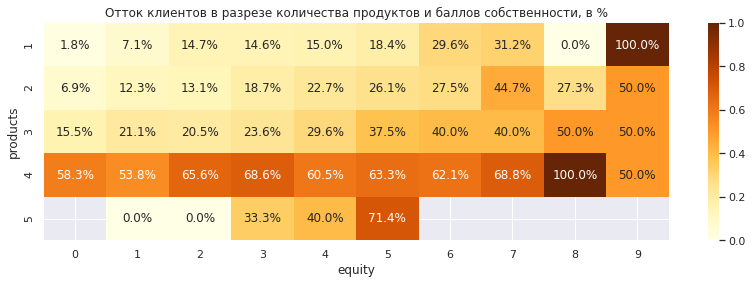

In [85]:
# зададим размер фигуры
plt.figure(figsize=(14,4))

# создадим хитмэп
sns.heatmap(
    # построим сводную таблицу для оценки уровня оттока в разрезе баллов собственности и продуктов
    (data.pivot_table(index='products', columns='equity', values='churn', aggfunc='mean')), 
    annot=True,  # включим подписи ячеек
    cmap='YlOrBr',  # зададим цветовую схему
    fmt='.1%'  # установим формат вывода значений в ячейках
)

# зададим заголовок графика и выведем его на экран
plt.title('Отток клиентов в разрезе количества продуктов и баллов собственности, в %')
plt.show()

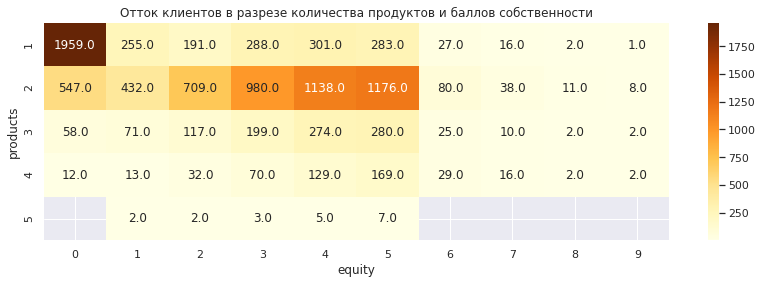

In [86]:
# зададим размер фигуры
plt.figure(figsize=(14,4))

# создадим хитмэп
sns.heatmap(
    # построим сводную таблицу для оценки уровня оттока в разрезе баллов собственности и продуктов
    (data.pivot_table(index='products', columns='equity', values='churn', aggfunc='count')), 
    annot=True,  # включим подписи ячеек
    cmap='YlOrBr',  # зададим цветовую схему
    fmt=''  # установим формат вывода значений в ячейках
)

# зададим заголовок графика и выведем его на экран
plt.title('Отток клиентов в разрезе количества продуктов и баллов собственности')
plt.show()

Наиболее проблемная зона - это клиенты, у которых 4 продукта банка (474 человека), по всем баллам собственности для них отток составляет 50% и выше. За искслючением некоторых блоков мы видим, что чем выше балл собственности, тем выше процент оттока. <br>
Нам уже известно, что больше всего клиентов с 1 и 2мя продуктами и средний % оттока по данным датафрейма - 18%. <br>
Для пользователей с одним продуктом процент оттока свыше 18 начинается с балла собственности 5, для клиентов с двумя продуктами процент свыше 18 - с балла собственности 3. Самые низкие проценты оттока у клиентов с 1-2 продуктами и баллами собственности 0-1.<br>
При этом самой многочисленной является группа клиентов с 1 продуктом и нулевым баллом собственности, однаков численность клиентов с 2-мя продуктами и баллами собственности от 3х суммарно превосходит данную группу.<br>
Кроме того, подтвердилось одно из наших предположений в части колебаний показателей для клиентов с 5 продуктами или с 8-9 баллами собственности, данные группы немногочисленны и соответственно очень чувствительны к изменению тех или иных показателей.<br>

Перейдем к анализу оттока оставшихся категорий в разрезе их пар с числом продуктов 

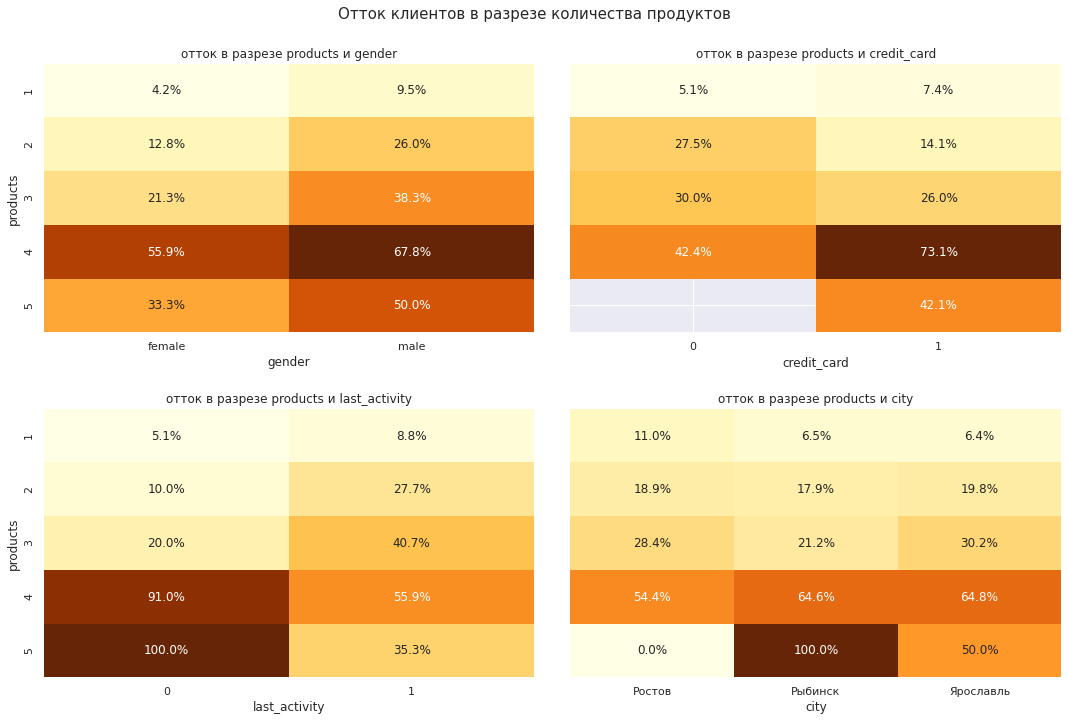

In [87]:
# зададим список столбцов для анализа
columns = ['gender', 'credit_card', 'last_activity', 'city']

# создадим сетку для построения графиков 2*2 и выровняем графики по оси y
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)
# зададим интервал между графиками
plt.subplots_adjust(hspace=0.5)
# зададим общее имя графиков
fig.suptitle('Отток клиентов в разрезе количества продуктов', fontsize=15, y=1)

# определим цикл для создания хитмэпов
for column, ax in zip(columns, axs.ravel()):
    # сформируем сводную таблицу для построения хитмэпов в разрезе продуктов и заданного списка колонок
    df = data.pivot_table(index='products', columns=column, values='churn', aggfunc='mean')
    # зададим параметры хитмэп
    sns.heatmap(df, annot=True, cmap='YlOrBr', fmt='.1%', cbar=False, ax=ax)
    # зададим имя хитмэп
    ax.set_title(f'отток в разрезе products и {column}', fontsize=12)
    # исключим наименование оси у для подграфиков
    ax.set_ylabel('')

# исключим любые не используемые графики, если число колонок меньше, чем у графиков
for i in range(len(columns), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

# установим название оси y для графика, а также настроим слои во избежания наложения слоев
plt.setp(axs[:, 0], ylabel='products')
plt.tight_layout(h_pad=2, w_pad=3)

# выведем график на экран
plt.show()

Самый высокий процент оттока у пользователей с 4 продуктами. Самые лояльные - клиенты с одним продуктом.
В разрезе количества продуктов и признаков:
- % оттока мужчин выше, чем у женщин,
- клиенты, обладающие кредитной картой и количеством продуктов от 3х чаще попадают в отток, для клиентов без кредитной карты отток увеличивается уже с 2х продуктов, при этом необходимо обратить внимание, что в разрезе продуктов и наличия кредитной карты % оттока попеременно выше, то у пользователей кредиткой, то у тех, кто кредиткой не пользуется,
- активные клиенты чаще уходят в отток для продуктов от 1 до 3 включительно, у неактивнык клиентов с 4 и 5 продуктами процент оттока больше 90% и выше, чем у активных, однако таких клиентов во всем датафрейме ~5%,
- среди городов картина приблизительно одинаковая - уровень оттока растет с количеством используемых продуктов, для клиентов с 5-ью продуктами отток выше в Рыбинске, но в клиентов с 5 продуктами всего 19 чел. по банку.

<a id="correlation"></a>
<b> Корреляционный анализ  

Построим матрицу корреляций, чтобы завершить исследовательский анализ данных и окончательно установить наличие/отсутствие взаимосвязей между признаками клиентов

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'gender_code']


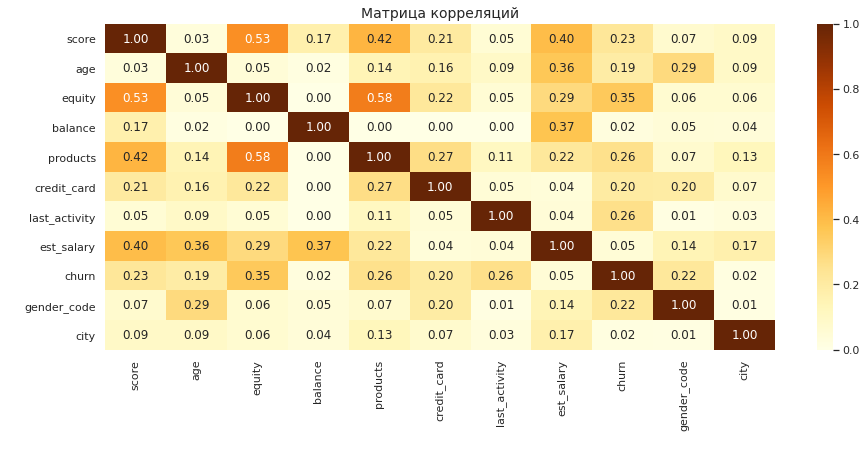

In [89]:
phik_corr = ((data
              .drop(['user_id', 'gender', 'rostov', 'rybinsk', 'yaroslavl', 'balance_na'], axis= 1))
             .phik_matrix())

# зададим параметры фигуры
plt.figure(figsize=(15, 6))
# зададим параметры графика и подписи ячеек
sns.heatmap(phik_corr, annot=True, cmap='YlOrBr', fmt='.2f')
# зададим подписи осей, а также угол поворота надписей по оси У

plt.title('Матрица корреляций', fontsize = 14)
plt.xlabel(' ')
plt.ylabel(' ')
plt.yticks(rotation = 0)

# выведем график на экран
plt.show()

В соответствии с матрицой корреляции можно отметить, что у целевого признака оттока (churn) отсутствуют явные и сильные взаимсвязи с какими-либо признаками, мы можем наблюдать слабые или средние (на нижней границе со слабыми) взаимосвязи целевого признака (churn) с такими показателями, как: 
- балл кредитного скоринга (score) - 0.23,<br>
- количество продуктов (products) - 0.26,<br>
- активность клиентов (last_activity) - 0.26,<br>
- балл собственности (equity) - 0.35.<br>

Среди иных категорий наиболее сильными корреляциями обладают между собой такие признаки, как:<br>
- балл кредитного скоринга (score) и оценочный доход (esy_salary) - 0.40,<br>
- балл кредитного скоринга (score) и количество продуктов (products) - 0.42,<br>
- балл кредитного скоринга (score) и балл собственности (equity) - 0.53,<br>
- количество продуктов (products) и балл собственности (equity) - 0.58.<br>

Вероятнее всего, балл скорринга формируется на основании указанных показателей.

<b> По итогам исследовательского анализа мы можем сделать следующие выводы: </b><br>

- мы проанализировали клиентов банка с точки зрения их оттока в разрезе всех основных показателей и категорий, а также рассмотрели особенности оттока и распределения клиентов банка в разрезе баланса, уровня доходов, возрастных групп, количества продуктов и баллов собственности.<br>

- в связи с этим мы можем составить портрет типичного клиента банка:<br>
-- с точки зрения гендера: мужчины и женщины распределены в равных долях,<br>
-- больше всего клиентов в возрасте 32-37 лет,<br>
-- 59% клиентов - из города Ярославль,<br>
-- 51% клиентов имеют 2 продукта, <br>
-- 68% клиентов владеют кредитной картой,<br>
-- самые высокие показатели медианного баланса у клиентов без кредитной карты, клиентов с баллом собственности 5 и количеством продуктов 4,<br>
-- медианный скоринговый балл составляет около 850,<br>
-- 52% клиентов - активные пользователи,<br>
-- в 82% случаях клиенты сохраняют свою лояльность банку.<br>

- чаще других в отток попадают:<br>
-- мужчины с балансом на счете более 800 тысяч и с оценочным доходом более 100 тысяч,<br>
-- в возрасте до 35 лет и в промежутке 50-60 лет,<br>
-- с баллом собственности от 3 и количеством продуктом от 2х,<br>
-- без кредитной карты и более активные клиенты,<br>
-- со скоринговым баллом 800-950,<br>
-- существенного влияния города на отток не установлено.<br>

- уровень доходов у лиц с балансом выше 800 тысяч превышает медианный уровень дохода у лиц с балансом до 800 тыс.,<br>
- женщины с более низким доходом более лояльны нежели мужчины с более высоким доходом,<br>
- медианные значения дохода у женщин незначительно ниже, чем у мужчин,<br>
- медианные показатели дохода и баланса ниже у лояльных клиентов,<br>

- с точки зрения числа продуктов и баллов собственности:<br>
-- с увеличением числа продуктов растет среднее значение баланса на счете и количество баллов собственности, также растет процент оттока клиентов, максимальный показатель оттока в 63% у клиентов с 4 продуктами,<br>
-- самый высокий медианный оценочный доход у клиентов с одним продуктом, самый низкий - с 3 продуктами,<br>
-- у клиентов с 1-2 продуктами, а также 4-5 продуктами кредитная карта преимущественно присутствует, у клиентов с 3 продуктами - наоборот,<br>
-- уровень пользования кредитной картой снижается по мере роста числа используемых продуктов (до 3х) и баллов собственности,<br>
-- наиболее проблемная зона в разрезе данных показателей это клиенты с 4-мя продуктами,<br>
-- для пользователей с одним продуктом процент оттока свыше 18% (среднебанковский) начинается с балла собственности в 5, для клиентов с двумя продуктами - с балла собственности 3.<br>
-- самые низкие проценты оттока у клиентов с 1-2 продуктами и баллами собственности 0-1. <br>

- с учетом роста медианного баланса на счета у клиентов по мере взросления (до предпенсионного возраста), а также сокращения числа использования кредитных карт, можно предположить, что клиенты могут быть знакомы с инвестициями, доверительным управлением, или же заниматься бизнесом и получать дивиденды на счета в банке<br>

- проведенный корреляционный анализ с помощью phik-библиотеки фактически подтвердил, что у целевого признака оттока (churn) отсутствуют явные и сильные взаимсвязи с какими-либо признаками, мы можем наблюдать слабые или средние (на нижней границе со слабыми) взаимосвязи целевого признака (churn) с такими показателями, как:<br>
-- балл кредитного скоринга (score) - 0.23,<br>
-- количество продуктов (products) - 0.26,<br>
-- активность клиентов (last_activity) - 0.26,<br>
-- балл собственности (equity) - 0.35.<br>
  
- при этом имеются взаимосвязи между собой у таких признаков, как:<br>
-- балл кредитного скоринга (score) и оценочный доход (esy_salary) - 0.40,<br>
-- балл кредитного скоринга (score) и количество продуктов (products) - 0.42,<br>
-- балл кредитного скоринга (score) и балл собственности (equity) - 0.53, <br>
-- количество продуктов (products) и балл собственности (equity) - 0.58. <br>



<a id="hypothesis"></a>
# Проверка статистических гипотез  

Подготовим данные и избавимся от пропусков в них.

In [91]:
hyp_df = data.copy()
hyp_df.dropna(inplace=True)

In [92]:
hyp_df['est_salary']=hyp_df['est_salary']*1000000

In [94]:
def plot_hypotheses(data_1, data_2, title = '', label_1 = '', label_2 = '', x_label = '', lim = (None, None)):
    
    """
    Функция для построения гистограмм для двух выборок.

    Аргументы:
    data1, data2: датафреймы с выборками для построения графиков.
    title: наименование графика.
    label_1, label_2, x_label: подписи данных на легенде.
    lim: лимит значений по оси х.
    """

    plt.figure(figsize=(15,7))
    
    # гистограмма для двух выборок
    sns.histplot(data = data_1, color = '#fc8d62',alpha = .7, label=label_1)
    sns.histplot(data = data_2, color = '#66c2a5',alpha = .7, label=label_2)
    
    # линия срединного значения для показателей выборок
    plt.axvline(data_1.mean(), c='k', ls='-', lw=2, label='средний' + ' ' + label_1)
    plt.axvline(data_2.mean(), c='k', ls='--', lw=2, label='средний' + ' ' + label_2)
    
    #  подписи осей и графика, выведение графика на экран
    plt.title(title,fontsize = 14)
    plt.xlabel(x_label, fontsize = 12)
    plt.ylabel('Количество клиентов', fontsize = 12)
    plt.xlim(lim)
    plt.legend()
    plt.show()

<b> Гипотеза о различии дохода между теми клиентами, которые ушли и теми, которые остались.

In [95]:
# посчитаем дисперсию и средние значения доходов клиентов в оттоке и оставшихся
var_churn_0 = np.array(hyp_df.query('churn == 0')['est_salary'])
var_churn_1 = np.array(hyp_df.query('churn == 1')['est_salary'])

print('Дисперсия дохода оставшихся клиентов:', np.var(var_churn_0))
print('Дисперсия дохода ушедших клиентов:', np.var(var_churn_1))
print()
print('Средняя дохода оставшихся клиентов:', np.mean(var_churn_0))
print('Средняя дохода ушедших клиентов:', np.mean(var_churn_1))

Дисперсия дохода оставшихся клиентов: 9655007321.945189
Дисперсия дохода ушедших клиентов: 14523370068.190046

Средняя дохода оставшихся клиентов: 117599.73005264052
Средняя дохода ушедших клиентов: 147087.27772978958


Сформулируем нулевую и альтернативную гипотезы:

`H0`: средние показатели дохода клиентов, кто ушел в отток и теми, кто остался - равны <br>
`H1` : средние показатели дохода клиентов, кто ушел в отток и теми, кто остался - не равны <br>

Уровень статистической значимости примем равным `5%`.

Создадим две выборки с доходом клиентов, которые остались и ушли из банка.

In [96]:
salary_left = hyp_df.query('churn == 1')['est_salary']
salary_stay = hyp_df.query('churn == 0')['est_salary']
print(f'\nРазмер выборки ушедших клиентов - {len(salary_left)} \nРазмер выборки оставшихся - {len(salary_stay)}')


Размер выборки ушедших клиентов - 1806 
Размер выборки оставшихся - 5889


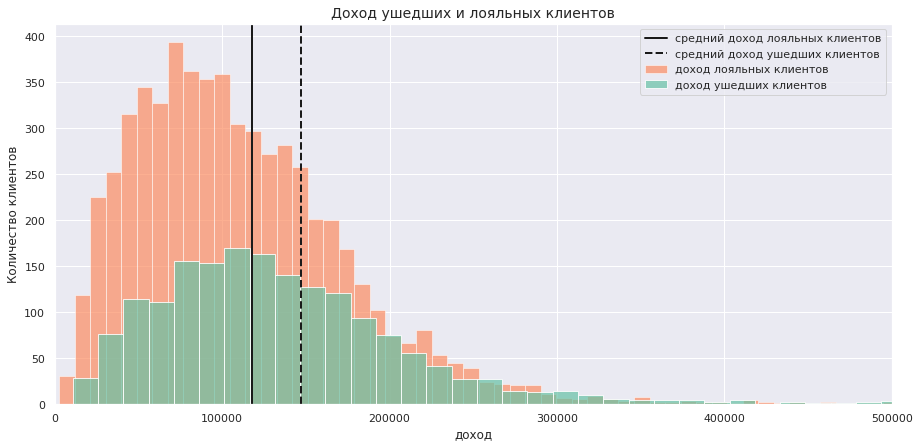

In [97]:
plot_hypotheses(salary_stay, salary_left, 'Доход ушедших и лояльных клиентов',\
                'доход лояльных клиентов', 'доход ушедших клиентов',\
                'доход', (0, 500000))

Используем t-тест для двух независимых выборок с параметром equal_var = False с учетом различий в дисперсии для выборок.

In [98]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(salary_stay, salary_left, equal_var = False)

# посмотрим p-value
print('p-value: ', results.pvalue)

# вывод 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Недостаточно оснований отвергнуть нулевую гипотезу')   

p-value:  5.830593329228803e-21
Отвергаем нулевую гипотезу


Т.об., вероятность того, что средний доход ушедщих и лояльных клиентов равен, невероятно мала, и гипотеза о равенстве дохода отвергается в пользу альтернативной.

<a id="segmentation"></a>
# Предварительные выводы и пояснения в рамках сегментации.

По итогам проведения анализа выделим основные критерии, на основании которых мы будем осуществлять сегментацию пользователей.
Для заказчика мы хотели бы сразу внести ясность, что с нашей стороны рассматривалось значительное число критериев, которые могут быть включены в сегментацию, однако выбор был сделан в пользу трехуровневой модели сегментации клиентов на основе таких характеристик как `количество продуктов (products)`, `балл собственности (equity)`, `активность пользователя (last_activity)`.
Данные критерии были выбраны с учетом проведенного анализа, а также следующих фактов:
- прослеживается рост оттока пользователей по мере роста числа продуктов и балла собственности, а также для неактивных / активных пользователей,
- прослеживается рост медианного баланса по мере роста числа продуктов и балла собственности до определенного уровня,
- необходимость выделения умеренного числа групп (в нашем случае 6-8 групп, рекомендуемое число групп - 8, минимальное обязательное в рамках нашего видения - 6) с численностью от 400 до 2500 чел.,
- наличие выраженных изменений в рамках данных групп по таким критериям, как к примеру, использование кредитной карточки (т.к. для лиц с 1 продуктом кредитная карта имеется у большинства пользователей, а у лиц с 3 продуктами только у 1 из 3, что позволит девирсифицировать и усовершенствовать стратегию работы с клиентами не только в рамках стратегии кредитования, но и в рамках иных продуктов, в т.ч. приносящих пассивный доход),
- разделение пользователей на активных и пассивных позволит также диверсифицировать стратегию работы с клиентами и оперативнее реагировать на замечания лиц, которые пользуются на постоянной основе сервисами банка и могут предоставить оперативный фид-бек по действующим продуктам и их условиям, качестве сервиса,
- баллы собственности, кроме того, позволят на ранних этапах определить лиц, которые могут перерасти в VIP или состоятельный сегмент, проработать с ними кросс-продажи продуктов на начальных этапах для вовлечения в пользование большим числом банковских сервисов, а также сформировать категорию лиц, располагающими потенциально источниками дохода вне банка-заказчика ввиду наличия 3+ объектов в собственности,
- также данные критерии (а именно, products и equity) имеют средний уровень или верхнюю границу слабой корреляции с баллом кредитного скоринга (который имеет в свою очередь среднюю корреляцию с уровнем дохода), наличием кредитной карты, средним уровнем оценочного дохода,
- наличие также изменений в уровнях медианного баланса в рамках данной сегментации, а также изменений в превалирующем гендере в разрезе продуктов.

Дополнительные пояснения почему ряд факторов не были взяты в качестве критериев сегментации как самостоятельные единицы:
- гендерная принадлежность: распределение клиентов фактически 50/50 в общей численности, существенное изменение численного соотношения мужчин / женщин по мере взросления, вероятность различия в уровне оттока в т.ч. в различной психологической модели поведения и, как следствие, необходимость более тщательной и дорогостоящей стратегии, изменения соотношения уровней оттока мужчин к женщинам и к среднебанковскому в различных возрастных группах, наличие средней корреляции лишь с возрастом и слабой с наличием кредитных карт;
- возраст: динамичность групп и необходимость выделения как минимум 4 групп в рамках возраста с уч. анализа оттока, существенные различия в численности групп, где группа лиц среднего возраста в 4 раза превышает группу пенсионного возраста, наличие различий в уровнях оттока по группам, наличие некоторых специфик, нехарактерных для иных групп или среднебанковских (отток на низких уровнях дохода у лиц 50-60 лет), необходимость дальнейшего дробления групп для стабилизации сегментации, что приведет к их значительному количеству и невысокой численности клиентов в группе, потенциальная потребность в сегментации в паре с гендерным признаком. В случае необходимости у заказчика в будущем выделения сегментов по возрасту считаем необходимым отметить, что исходя из имеющихся данных и проведенного анализа (включая доп.), границу для возрастных групп возможно установить на уровне 60 лет (до 60 и свыше), т.к. пользователи после 60 лет обладают высоким уровнем лояльности, однако группу свыше 60 лет все равно следует дробить на группу лиц с 1-2 продуктами и с 3+ продуктами, учитывая корреляции которые показывают другие категории;
- баланс: наличие существенного числа пропусков в данных (23%), нижняя граница средней корреляции только с уровнем заработной платы. Возможно рассмотрение данного критерия как замены equity-критерия в будущем и установления пограничного значения в уровне баланса счетов в 800 тыс. руб. (границы изменения оттока по банку), однако для принятия решения об этом необходимо урегулирование вопроса с пропусками и наличия максимально близкого к 100% заполнения данных, а также доп. анализ в виде категорий продуктов, которыми пользуются клиенты, что позволит четче определить потенциальные причины в уровне баланса, активности пользователей, а также в пограничном размере баланса для сегментации,
- город: преимущественная численность клиентов из Ярославля, фактически отсутствие корреляции с другими категориями;
- скорринговый балл и наличие кредитной карты: необходимость дополнительной градации скорринговых значений на, как минимум, 3 уровня, узконаправленность потенциальной кредитной стратегии, корреляция и потенциальная зависимость скоррингового балла от ряда иных первоначально причинных факторов (доход, балл собственности и прочее).

<a id="conclusions"></a>
# Общие выводы и рекомендации.

-<b> в рамках загрузки и предобработки данных </b> мы привели названия столбцов user_id и est_salary были приведены к змеиному регистру, в столбце age были удалены пропуски, которые составляли 0,26% первоначального датафрейма, а тип данных заменен с float на int64, были рассмотрены и выявлены неявные дубликаты, в частности, в столбце user_id, которые по нашему предположению носят технический характер, о чем следует сообщить заказчику при встрече, пропуски в данных в столбце balance оставили без изменений (23% данных в датафрейме), учитывая наличие корреляцию с иными столбцами, а также существенное число таких пропусков в датафрейме. <br>

-<b> в рамках проведенного исследовательского анализа </b> <br>

-мы определили <b> портрет типичного клиента банка </b> с точки зрения гендерного вопроса мужчины / женщины распределены равномерно, возрасте 32-37 лет, город Ярославль (59% клиентов), пользуется 2 продуктами (51% клиентов), владеет кредиткой (68%), имеет  медианный скоринговый балл 850, активный пользователь (52%), лоялен к банку (82%), медианный доход 120 тыс. руб <br>

-установили, что чаще других <b> в отток попадаю </b> мужчины с балансом на счете более 800 тысяч и с оценочным доходом более 100 тысяч, в возрасте до 35 лет или в 50-60 лет, с баллом собственности от 3 и количеством продуктов свыше 2х, без кредитной карты и более активные клиенты, со скоринговым баллом 800-950, существенного влияния города на отток не установлено. <br>

-<b> с точки зрения числа продуктов и баллов собственности </b>- с увеличением числа продуктов растет среднее значение баланса на счете и количество баллов собственности, также растет процент оттока клиентов, максимальный показатель оттока в 63% у клиентов с 4 продуктам, самый высокий медианный оценочный доход у клиентов с одним продуктом, самый низкий - с 3 продуктами,  уровень пользования кредитной картой снижается по мере роста числа используемых продуктов (до 3х) и баллов собствености, наиболее проблемная зона в разрезе данных показателей это клиенты с 4-мя продуктами, для пользователей с одним продуктом процент оттока свыше 18% (среднебанковский) начинается с балла собственности в 5, для клиентов с двумя продуктами - с балла собстости в 3, самые низкие проценты оттока у клиентов с 1-2 продуктами и баллами собственности.

-<b> проведенный корреляционный анализ (phik-библиотека) фактически подтвердил: </b> у целевого признака оттока (churn) отсутствуют явные и сильные взаимсвязи с какими-либо признаками, мы можем наблюдать слабые или средние (на нижней границе со слабыми) взаимосвязи целевого признака (churn) с такими показателями, как: балл кредитного скоринга (score) - 0.23, количество продуктов (products) 0.26, активность клиентов (last_activity) 0.26, балл собственности 0,35.

-<b> в рамках проверки статистических гипотез: </b> мы отвергли гипотезы о равенстве среднего оценочного дохода и скоррингового балла у лояльных и ушедших пользоваентов.

В рамках предложенной нами сегментации с т.зр. комбинации категорий количества продуктов, балла собственности и активности пользователя мы рекомендуем выделить следующие сегменты:<br>

- <b>Сегмент 1: клиенты, имеющие в банке 1 продукт и балл собственности не выше двух</b> (2405 чел.), самый лояльный и массовый сегмент. Фактически данный сегмент является базовым массовым сегментом, преимущественным продуктом которого является кредитная карта, в отношении данного сегмента `рекомедуем` осуществлять поддержание качественного и профессионального сервиса, осуществлять периодические проверки знаний сотрудников и их соответствие стандартам, предлагать клиентам заполнить карты с продуктами, в которых они могли бы быть заинтересованы, для расширения в будущем линейки продуктов. Триггер изменения в части политики в отношении данного клиента - существенные изменения в его численности или уровне лояльности.<br>
    
- <b> Сегмент 2: клиенты, имеющие в банке 1 продукт c баллом собственности 3+, неактивные</b> (466 чел.). Фактически данный сегмент отличается от массового своей пассивностью и более высоким баллом собственности, чуть большим оттоком (в 2 раза больше 1-го сегмента, но все еще в 2 раза ниже среднебанковского), и в 3 раза более высоким медианным балансом средств на счетах, для данного сегмента `рекомедуем дополнительно` при работе в рамках визитов клиентов в банк проведение кросс-продаж иных банковских продуктов, в т.ч. приносящих пассивный доход, как для самих клиентов, так и для членов их семей (при их наличии). Тригер - рост уровня оттока и снижение баланса счетов.<br>
 
- <b> Сегмент 3: клиенты, имеющие в банке 1 продукт c баллом собственности 3+, активные </b> (452 чел.). Для данного сегмента характерен уровень оттока, превышающий среднебанковский и в 3 раза превышающий, при этом данные лица - все еще в большинстве своем держатели кредитных карт, однако имеющие медианный баланс в 526 тыс. Для данного сегмента `рекомедуем дополнительно` заполнение анкет удовлетворенности сервисами банка, оценку со стороны банка возможности удовлетворения данных требований, т.к. фактически это все еще клиенты, использующие 1 продукт - кредитную карту и причина их оттока может быть обусловлена отсутствием потребности в дальнейшем кредитовании. Тригер - сокращение / рост уровня оттока и снижение баланса счетов. <br>

- <b> Сегмент 4: клиенты, имеющие в банке 2 продукта c баллом собственности не более 2 </b> (1688  чел.). Для данного сегмента наблюдается постепенное сокращение использования кредитных карт (снижение доли таких пользователей с 84-95% до 70%), рост медианного баланса по отношению к массовому сегменту (сегмент №1) и рост уровня оттока по сравнению с 1-м и 2-м сегментом. Поскольку данный сегмент уже более вовлечен в использование банковских продуктов нежели клиенты с 1 продуктом мы `рекомендуем` наращивание дальнейшего присутствия банка в данных клиентах путем кросс-продаж, предложения кредитов, возможно, овердрафтных на небольшие суммы к уже имеющимся счетам, и использование всего комплекса мер, характерных для первых 2х сегментов (стандарты сервиса, проверка знаний сотрудников, заполнение карт с интересующими продуктами). <br>
 
- <b> Сегмент 5: клиенты, имеющие в банке 2 продукта c баллом собственности 3+, неактивные </b> (1639  чел.). Для данного сегмента наблюдается дальнейшее сокращение кредитного проникновения в клиента, более высокие показатели медианного баланса нежели у аналогичных клиентов с 1 продуктом, уровень оттока незначительно превышает 4-й сегмент. Для данного сегмента `рекомендации` аналогичны сегменту с одним продуктом (стандарты сервиса, кросс-продажи продуктов для клиентов и членов их семей для увеличения или диверсификации пассивного дохода) `+` потенциальное информирование наиболее заинтересованных клиентов о том, что доп. оформление еще 1 категории продуктов (до числа продуктов в 3), предоставит им возможность закрепиться за персональным менеджером в рамках массового активного/высоко-состоятельного сегмента. <br>
   
- <b> Сегмент 6: клиенты, имеющие в банке 2 продукта c баллом собственности 3+, активные </b> (1792  чел.). Для данного сегмента наблюдается дальнейшее сокращение кредитного проникновения в клиента (55% владеют кредиткой), а также существенный уровень оттока в 34%. Для данного сегмента `рекомендации` - стандарты сервиса, обязательное анкетирование удовлетворенностью клиентов, оценка возможности урегулирования данных моментов `+` потенциальное информирование наиболее заинтересованных во взаимодействии с банком клиентов о том, что доп. оформление еще 1 продукта другой категории (до числа продуктов в 3), предоставит им возможность закрепиться за персональным менеджером в рамках массового активного/высоко-состоятельного сегмента `+` в исключительных случаях (доп. мера по сравнению с пред. сегментами) - предложение индивидуальных условий о снижении процентной ставки по кредитам (не в убыток банку), а также перевод клиентов в 7-й сегмент (массовый активный/высоко-состоятельный) с индвидиуальным менеджером. <br>
    
- <b> Сегмент 7: клиенты, имеющие в банке 3 продукта </b> (1038 чел.) - массовый активный и высокосостоятельный сегмент. Для данного сегмента в среднем наблюдается высокий уровень оттока (28,6%), низкий уровень наличия кредитных карт (36%), данная группа является в среднем самой возрастной (46 лет), однако в среднем группа является достаточно пассивной (41% активных пользователей). `Рекомендации для данного сегмента` включают в себя `предоставление персонального менеджера в рамках обслуживания в банке, возможность кредитования на более лояльных (но не значительно) нежели массовый сегмент условиях`, а также поддержание высоких стандартов сервиса (для активных клиентов - заполнение анкет удовлетворенности, карт интересующих продуктов). <br>

- <b> Сегмент 8: клиенты, имеющие в банке 4-5 продуктов </b> (493 чел.) - самая молодая в среднем группа, у которой отмечается наибольший отток клиентов. `Рекомендации для данного сегмента` - отнесение данных клиентов в число vip-клиентов (5% общей базы), анализ причин существенного оттока пользователей и экономической целесообразности и возможности их удержание, обслуживание с персональным менеджером в отдельном помещении, предложение индивидуальных условий для бизнеса (при наличии такового у клиента) и непосредственно для клиента, активный сбор информации об интересующих и актуальных продуктах для клиента, не оформленных или отсутствующих в банке, поздравление клиентов с днем рождения. <br>